#BAX423 Final Project

Team 8: Mia Chen,Rebecca Wei, Chris Nathi, Pejmahn Choupani, Manik Chandrasekhar	

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import datetime

import regex as re

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
housing = pd.read_csv("/content/drive/Shareddrives/BAX423_Final_Project/Data/Combine.csv")
housing.info()
performance = {}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12765 entries, 0 to 12764
Data columns (total 28 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Unnamed: 0                                                                                  12765 non-null  int64  
 1   SALE TYPE                                                                                   12765 non-null  object 
 2   SOLD DATE                                                                                   12765 non-null  object 
 3   PROPERTY TYPE                                                                               12765 non-null  object 
 4   ADDRESS                                                                                     12765 non-null  object 
 5   CITY                                   

In [ ]:
housing.drop(['Unnamed: 0','SALE TYPE', 'ADDRESS','LOCATION','$/SQUARE FEET', 'HOA/MONTH','STATUS', 
              'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME','URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
              'SOURCE','MLS#','FAVORITE', 'INTERESTED'],axis=1,inplace=True)

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12765 entries, 0 to 12764
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SOLD DATE           12765 non-null  object 
 1   PROPERTY TYPE       12765 non-null  object 
 2   CITY                12765 non-null  object 
 3   STATE OR PROVINCE   12765 non-null  object 
 4   ZIP OR POSTAL CODE  12765 non-null  object 
 5   PRICE               12765 non-null  float64
 6   BEDS                12693 non-null  float64
 7   BATHS               12286 non-null  float64
 8   SQUARE FEET         12671 non-null  float64
 9   LOT SIZE            11433 non-null  float64
 10  YEAR BUILT          12718 non-null  float64
 11  DAYS ON MARKET      12765 non-null  float64
 12  LATITUDE            12765 non-null  float64
 13  LONGITUDE           12765 non-null  float64
dtypes: float64(9), object(5)
memory usage: 1.4+ MB


In [ ]:
housing.head()

SOLD DATE              PROPERTY TYPE  ...   LATITUDE   LONGITUDE
0  December-29-2017                Condo/Co-op  ...  37.400010 -122.105262
1      July-18-2018  Single Family Residential  ...  37.386508 -122.091861
2  November-21-2018                Condo/Co-op  ...  37.408167 -122.111414
3      June-23-2020                Condo/Co-op  ...  37.397295 -122.103050
4     March-11-2021                  Townhouse  ...  37.375380 -122.077552

[5 rows x 14 columns]

## Data pre-processing

In [ ]:
#convert to correct data type

housing['SOLD DATE'] = housing['SOLD DATE'].apply(lambda x: datetime.datetime.strptime(x, '%B-%d-%Y'))
housing['Sold Year'] = housing['SOLD DATE'].apply(lambda x: x.year)
housing['Sold Quarter'] = housing['SOLD DATE'].apply(lambda x: x.quarter)
housing['Sold Year_quarter'] = housing['SOLD DATE'].apply(lambda x: str(x.year)+"-"+str(x.quarter))
#calculate the age of the properties at the date they were sold
housing['Age'] = housing['Sold Year']-housing['YEAR BUILT']

#City name unification
housing['CITY'] = housing['CITY'].apply(lambda x: x.upper())

#City name unification
if housing['ZIP OR POSTAL CODE'].dtypes !='object':
  housing['ZIP OR POSTAL CODE'] = round(housing['ZIP OR POSTAL CODE']).astype('int')
else:
  zipcode_re = re.compile('[0-9]{5}')
  housing['ZIP OR POSTAL CODE'] = housing['ZIP OR POSTAL CODE'].apply(lambda x:int(zipcode_re.findall(x)[0]))

In [ ]:
housing['ZIP OR POSTAL CODE'].unique()

array([94040, 94087, 94041, 94043, 94089, 94088, 94085, 94086, 94805,
       95014, 95051, 95050, 95126, 94544, 95054])

In [ ]:
#drop insignificant data

#PROPERTY TYPE
print("Before drop: ")
print(housing['PROPERTY TYPE'].value_counts())

housing = housing.loc[(housing['PROPERTY TYPE'] == 'Single Family Residential')|(housing['PROPERTY TYPE'] == 'Townhouse')|(housing['PROPERTY TYPE'] == 'Condo/Co-op')]
print("After drop: ")
print(housing['PROPERTY TYPE'].value_counts())
print('\n')

#City
print("Before drop: ")
print(housing['CITY'].value_counts())
for i in housing['CITY'].unique():
  if sum(housing['CITY']==i)<100:
    housing = housing.drop(housing[housing['CITY']==i].index)
print("After drop: ")
print(housing['CITY'].value_counts())
print('\n')

#Zip Code
print("Before drop: ")
print(housing['ZIP OR POSTAL CODE'].value_counts())
for i in housing['ZIP OR POSTAL CODE'].unique():
  if sum(housing['ZIP OR POSTAL CODE']==i)<100:
    housing = housing.drop(housing[housing['ZIP OR POSTAL CODE']==i].index)
print("After drop: ")
print(housing['ZIP OR POSTAL CODE'].value_counts())

Before drop: 
Single Family Residential    6927
Townhouse                    2419
Condo/Co-op                  2147
Mobile/Manufactured Home      724
Multi-Family (2-4 Unit)       435
Multi-Family (5+ Unit)         68
Other                          25
Vacant Land                    18
Unknown                         2
Name: PROPERTY TYPE, dtype: int64
After drop: 
Single Family Residential    6927
Townhouse                    2419
Condo/Co-op                  2147
Name: PROPERTY TYPE, dtype: int64


Before drop: 
SUNNYVALE        3827
SANTA CLARA      3777
MOUNTAIN VIEW    2431
CUPERTINO        1457
SAN JOSE            1
Name: CITY, dtype: int64
After drop: 
SUNNYVALE        3827
SANTA CLARA      3777
MOUNTAIN VIEW    2431
CUPERTINO        1457
Name: CITY, dtype: int64


Before drop: 
95051    1899
94087    1584
95014    1457
94043    1194
95050    1152
94086    1102
94040     901
94085     728
95054     725
94089     412
94041     336
94544       1
94805       1
Name: ZIP OR POSTAL CO

In [ ]:
print(housing[housing['LOT SIZE'].isna()]['PROPERTY TYPE'].value_counts())

#fill Lot Size of condo and mobile/manufactured home to 0
# housing.loc[(housing['LOT SIZE'].isna()) & (housing['PROPERTY TYPE']=='Mobile/Manufactured Home')]['PROPERTY TYPE'] = 0
housing.loc[(housing['LOT SIZE'].isna()) & (housing['PROPERTY TYPE']=='Condo/Co-op')]['LOT SIZE'] = 0
housing.loc[(housing['LOT SIZE'].isna()) & (housing['PROPERTY TYPE']=='Townhouse')]['LOT SIZE'] = 0

Condo/Co-op                  596
Townhouse                     24
Single Family Residential      6
Name: PROPERTY TYPE, dtype: int64


In [ ]:
#drop NA
housing = housing.dropna()

In [ ]:
housing['PROPERTY TYPE'] = housing['PROPERTY TYPE'].astype('category')
housing['CITY'] = housing['CITY'].astype('category')
housing['STATE OR PROVINCE'] = housing['STATE OR PROVINCE'].astype('category')
housing['ZIP OR POSTAL CODE'] = housing['ZIP OR POSTAL CODE'].astype('category')
housing['PRICE'] = housing['PRICE'].astype('int')
# housing['BEDS'] = housing['BEDS'].astype('category')
# housing['BATHS'] = housing['BATHS'].astype('category')
# housing['LOCATION'] = housing['LOCATION'].astype('category')
housing['SQUARE FEET'] = housing['SQUARE FEET'].astype('float64')
#housing['LOT SIZE'] = housing['LOT SIZE'].astype('int')
# housing['YEAR BUILT'] = housing['YEAR BUILT'].astype('category')
housing['DAYS ON MARKET'] = housing['DAYS ON MARKET'].astype('int')
# #housing['$/SQUARE FEET'] = housing['$/SQUARE FEET'].astype('int')
# #housing['HOA/MONTH'] = housing['HOA/MONTH'].astype('int')
# housing['STATUS'] = housing['STATUS'].astype('category')
housing['Age'] = housing['Age'].astype('int')

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10864 entries, 0 to 12764
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SOLD DATE           10864 non-null  datetime64[ns]
 1   PROPERTY TYPE       10864 non-null  category      
 2   CITY                10864 non-null  category      
 3   STATE OR PROVINCE   10864 non-null  category      
 4   ZIP OR POSTAL CODE  10864 non-null  category      
 5   PRICE               10864 non-null  int64         
 6   BEDS                10864 non-null  float64       
 7   BATHS               10864 non-null  float64       
 8   SQUARE FEET         10864 non-null  float64       
 9   LOT SIZE            10864 non-null  float64       
 10  YEAR BUILT          10864 non-null  float64       
 11  DAYS ON MARKET      10864 non-null  int64         
 12  LATITUDE            10864 non-null  float64       
 13  LONGITUDE           10864 non-null  float64   

# Time Series - House Price forecast

In [ ]:
zip_price_df = housing[['SOLD DATE', 'ZIP OR POSTAL CODE', 'PRICE']]
# zip_price_df['SOLD DATE'] = zip_price_df['SOLD DATE'].apply(lambda x: str(x.year)+"-"+str(x.month))
zip_price_df['SOLD DATE'] = zip_price_df['SOLD DATE'].apply(lambda x:x.strftime("%Y-%m-01"))
zip_price_df['SOLD DATE'] = pd.to_datetime(zip_price_df['SOLD DATE'])
zip_price_df2 = zip_price_df.groupby(['ZIP OR POSTAL CODE', 'SOLD DATE']).mean().sort_values(by = ['SOLD DATE','ZIP OR POSTAL CODE']).reset_index()
zip_price_df2.set_index('SOLD DATE', inplace = True)
zip_price_df2.head()

ZIP OR POSTAL CODE         PRICE
SOLD DATE                                  
2016-05-01              94040  1.438227e+06
2016-05-01              94041  1.755250e+06
2016-05-01              94043  9.793687e+05
2016-05-01              94085  1.120911e+06
2016-05-01              94086  1.302987e+06

In [ ]:
housing['ZIP OR POSTAL CODE'].unique()

[94040, 94087, 94041, 94043, 94089, ..., 94086, 95014, 95051, 95050, 95054]
Length: 11
Categories (11, int64): [94040, 94087, 94041, 94043, ..., 95014, 95051, 95050, 95054]

In [ ]:
zip_price_df2

ZIP OR POSTAL CODE         PRICE
SOLD DATE                                  
2016-05-01              94040  1.438227e+06
2016-05-01              94041  1.755250e+06
2016-05-01              94043  9.793687e+05
2016-05-01              94085  1.120911e+06
2016-05-01              94086  1.302987e+06
...                       ...           ...
2021-05-01              94089  1.432000e+06
2021-05-01              95014  2.658146e+06
2021-05-01              95050  1.329500e+06
2021-05-01              95051  1.518449e+06
2021-05-01              95054  1.612000e+06

[671 rows x 2 columns]

#### Plot

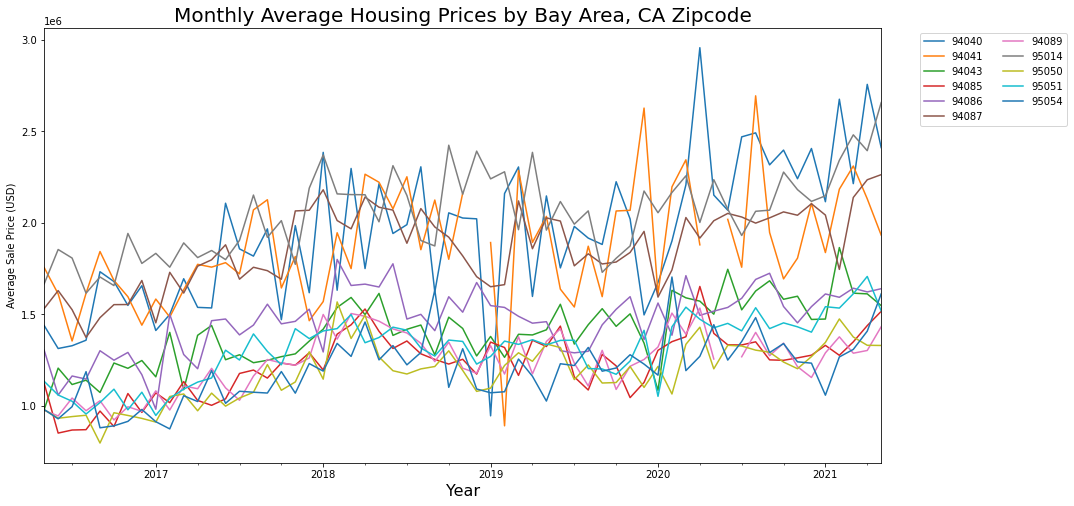

In [ ]:
for zipcode in zip_price_df2['ZIP OR POSTAL CODE'].unique():
    temp_df = zip_price_df2.loc[zip_price_df2['ZIP OR POSTAL CODE'] == zipcode]
    temp_df['PRICE'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Bay Area, CA Zipcode', fontsize = 20);
plt.show()

#### Seasonal Decomposition

In [ ]:
month_avg = zip_price_df2.groupby('SOLD DATE')['PRICE'].mean()
month_avg.head()

SOLD DATE
2016-05-01    1.260009e+06
2016-06-01    1.216852e+06
2016-07-01    1.196537e+06
2016-08-01    1.197967e+06
2016-09-01    1.256861e+06
Name: PRICE, dtype: float64

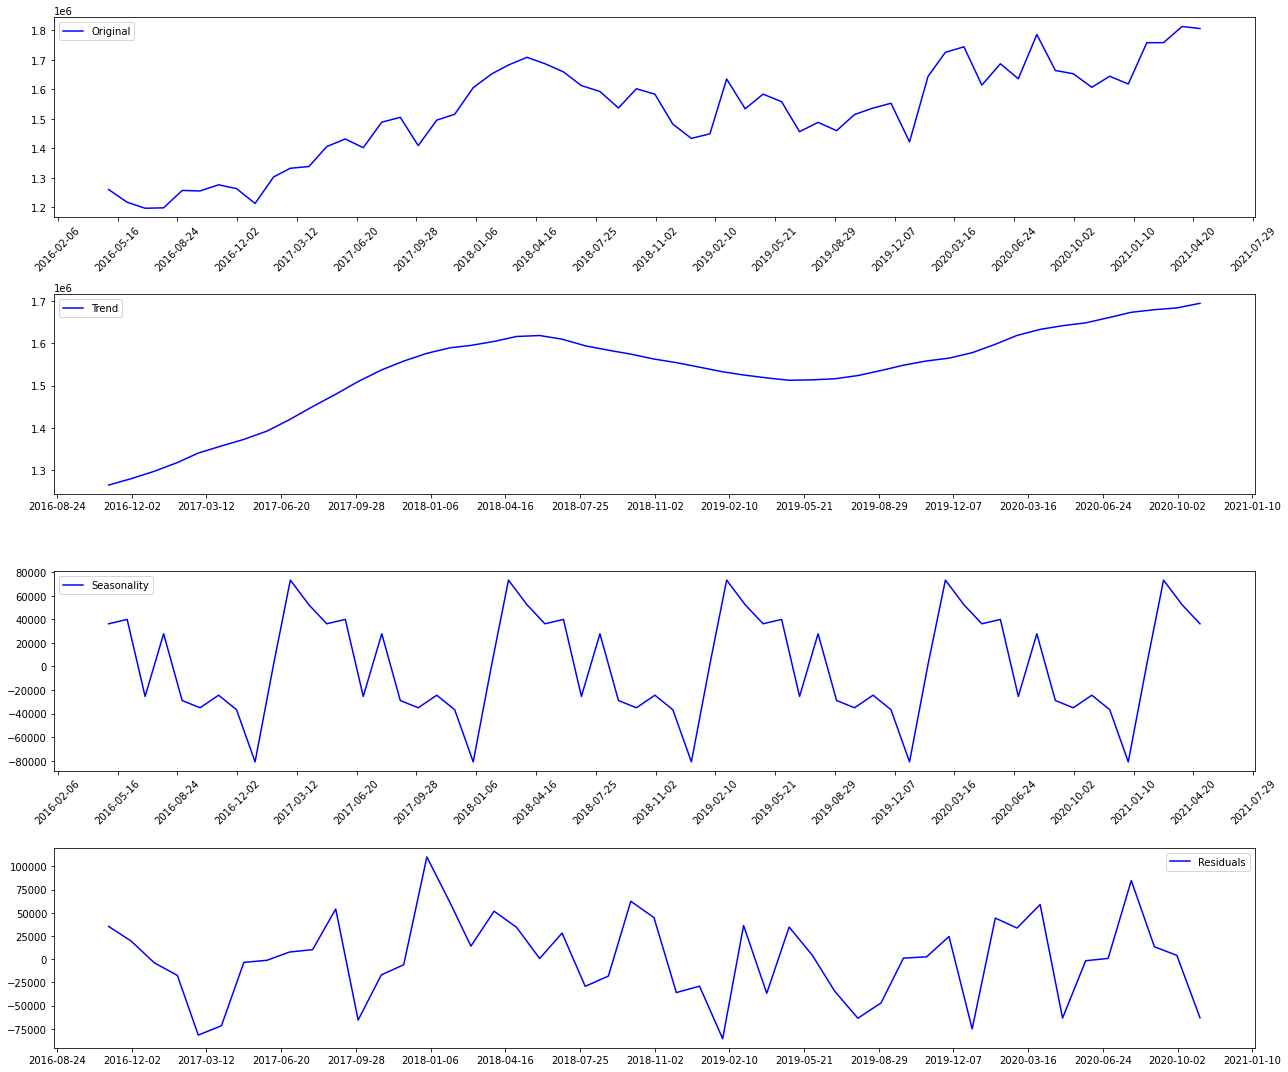

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(month_avg, model='additive')

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
ticker_spacing = 100
plt.figure(figsize=(18,15))
original_plot = plt.subplot(411)
original_plot.plot(month_avg, label='Original', color='blue')
original_plot.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.legend(loc='best')
plt.xticks(rotation = 45)

trend_plot = plt.subplot(412)
trend_plot.plot(trend, label='Trend', color='blue')
trend_plot.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.legend(loc='best')
# plt.xticks(rotation = 45)

seasonality_plot = plt.subplot(413)
seasonality_plot.plot(seasonal,label='Seasonality', color='blue')
seasonality_plot.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.legend(loc='best')
plt.xticks(rotation = 45)

residual_plot = plt.subplot(414)
residual_plot.plot(residual, label='Residuals', color='blue')
residual_plot.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.legend(loc='best')
# plt.xticks(rotation = 45)
plt.tight_layout()

### Autocorrelation

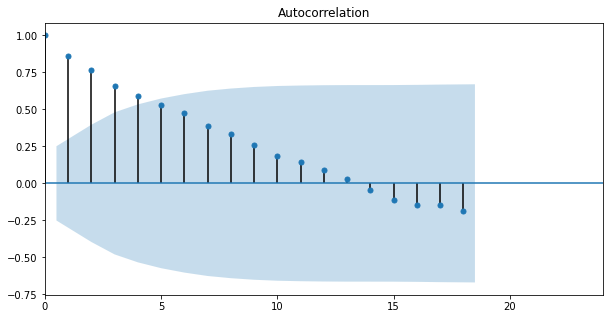

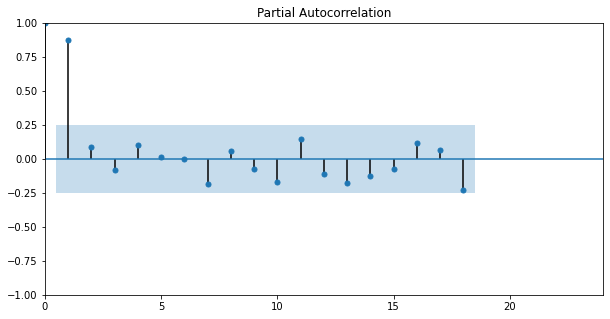

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,5
plot_acf(month_avg); plt.xlim(0,24); plt.show()
plot_pacf(month_avg); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

## Modeling - SARIMAX (SARIMA) and Holt-WInter Filter

### Step 1. Find the Zip code with highest ROI

In [ ]:
from statsmodels.tsa.stattools import adfuller
 
#Stationartiy Testing
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

In [ ]:
#Stationartiy Ploting
def TestStationaryPlot(ts):
  rol_mean = ts.rolling(window = 12, center = False).mean()
  rol_std = ts.rolling(window = 12, center = False).std()
  plt.plot(ts, color = 'blue',label = 'Original Data')
  plt.plot(rol_mean, color = 'red', linestyle='-.', label = 'Moving Average')
  plt.plot(rol_std, color ='black', linestyle='--', label = 'Std')
  plt.xticks(fontsize = 10)
  plt.yticks(fontsize = 10)
  plt.xlabel(u'Time (month)', fontsize = 10)
  plt.ylabel(u'Price', fontsize = 10)
  plt.legend(loc='best', fontsize = 10)
  plt.title(u'Moving Average and Std', fontsize = 10)
  plt.show(block= True)

In [ ]:
def multi_plot(zip_dfs, zip_list):

  for k, name in zip(zip_dfs, zip_list):
    
    try:
      print('Plot for', name)
      k.plot()
      plt.title(name)
      plt.show()

      #auto corr
      rcParams['figure.figsize']=10,4
      plot_acf(k.PRICE); plt.xlim(0,24); plt.show()
      plot_pacf(k.PRICE); plt.xlim(0,24); plt.ylim(-1,1);plt.show()
      
      #Stantionarity testing
      test_stationarity(k.PRICE)
      TestStationaryPlot(k.PRICE)


      #Deposition
      decomposition = seasonal_decompose(k, model='additive')

      #Gather the trend, seasonality, and residuals
      trend = decomposition.trend
      seasonal = decomposition.seasonal
      residual = decomposition.resid

      # Plot gathered statistics
      ticker_spacing = 100
      
      plt.figure(figsize=(10,10))
      original_plot = plt.subplot(411)
      original_plot.plot(month_avg, label='Original', color='blue')
      original_plot.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
      plt.legend(loc='best')
      plt.title(name)
      plt.xticks(rotation = 45)

      trend_plot = plt.subplot(412)
      trend_plot.plot(trend, label='Trend', color='blue')
      trend_plot.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
      plt.legend(loc='best')
      plt.xticks(rotation = 45)

      seasonality_plot = plt.subplot(413)
      seasonality_plot.plot(seasonal,label='Seasonality', color='blue')
      seasonality_plot.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
      plt.legend(loc='best')
      plt.xticks(rotation = 45)

      residual_plot = plt.subplot(414)
      residual_plot.plot(residual, label='Residuals', color='blue')
      residual_plot.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
      plt.legend(loc='best')
      plt.xticks(rotation = 45)
      
      plt.tight_layout()
    except:
      continue

In [ ]:
zip_price_df2['ZIP OR POSTAL CODE'].unique()

[94040, 94041, 94043, 94085, 94086, ..., 94089, 95014, 95050, 95051, 95054]
Length: 11
Categories (11, int64): [94040, 94041, 94043, 94085, ..., 95014, 95050, 95051, 95054]

#### fill NA with moving average

In [ ]:
zip_dfs = []
zip_list = np.array(zip_price_df2['ZIP OR POSTAL CODE'].unique())
for x in zip_list:
  df_1 = pd.DataFrame(zip_price_df2[zip_price_df2['ZIP OR POSTAL CODE']==x][['PRICE']].copy())

  #Fill NA with moving average
  rolling = df_1['PRICE'].rolling( 3,center=True,min_periods=1).mean()
  rolling_df = pd.DataFrame(rolling)
  df_1.update(rolling_df, overwrite = False)

  #change the frequecy to month start
  df_1.index = pd.DatetimeIndex(df_1.index.values, freq='MS')
  zip_dfs.append(df_1)

In [ ]:
multi_plot(zip_dfs, zip_list)

Output hidden; open in https://colab.research.google.com to view.

#### Model Tuning (Hyper-parameter adjustment)

In [ ]:
import itertools

# In the following coding, we will try every combination of p, d and q parameters where the value is 0, 1 or 2 to figure out which one can produce the best outcome in terms of lowest AIC
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
phat = dhat = qhat = range(0,2)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(phat, dhat, qhat))]
# pdqs =[(0, 0, 0, 12)]
print(pdq)
print(pdqs)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [ ]:
#Grid Search to find the best parameter that could return the lowest AIC
import statsmodels.api as sm
def ModelTuning(zip_dfs, zip_list, pdq, pdqs):

  ans = []

  for df, zip_code in zip(zip_dfs, zip_list):
      for para1 in pdq:
          for para2 in pdqs:
              try:
                  # #Use 80% for training
                  # train = df[:round(len(df)*0.8)]
                  # df.index = pd.DatetimeIndex(df.index.values, freq=frequency)
                  # print(df.freq)
                  # df.index = pd.period_range(min(df.index), max(df.index), freq=freq_model)
                  mod = sm.tsa.statespace.SARIMAX(df,                                                  
                                                  order = para1,
                                                  seasonal_order = para2,
                                                  enforce_stationarity = False,
                                                  enforce_invertibility = False)
                  output = mod.fit(maxiter=1000)
                  ans.append([zip_code, para1, para2, output.aic])
                  print('Result for {}'.format(zip_code) + ' ARIMA {} x {} : AIC Calculated = {}'.format(para1, para2, output.aic))
              except Exception as ex:
                print(ex)
                continue
  return ans

In [ ]:
tuning_ans = ModelTuning(zip_dfs, zip_list, pdq, pdqs)

Result for 94040 ARIMA (0, 0, 0) x (0, 0, 0, 12) : AIC Calculated = 1912.8957792742272
Result for 94040 ARIMA (0, 0, 0) x (0, 0, 1, 12) : AIC Calculated = 1511.330391928786
Result for 94040 ARIMA (0, 0, 0) x (0, 1, 0, 12) : AIC Calculated = 1400.395273724023
Result for 94040 ARIMA (0, 0, 0) x (0, 1, 1, 12) : AIC Calculated = 1046.9949322940233
Result for 94040 ARIMA (0, 0, 0) x (1, 0, 0, 12) : AIC Calculated = 1424.0994469403715
Result for 94040 ARIMA (0, 0, 0) x (1, 0, 1, 12) : AIC Calculated = 1410.9483870887404
Result for 94040 ARIMA (0, 0, 0) x (1, 1, 0, 12) : AIC Calculated = 1073.9708180181074
Result for 94040 ARIMA (0, 0, 0) x (1, 1, 1, 12) : AIC Calculated = 1044.913995801266
Result for 94040 ARIMA (0, 0, 1) x (0, 0, 0, 12) : AIC Calculated = 1846.8141594793942
Result for 94040 ARIMA (0, 0, 1) x (0, 0, 1, 12) : AIC Calculated = 1469.0154341972873
Result for 94040 ARIMA (0, 0, 1) x (0, 1, 0, 12) : AIC Calculated = 1370.29163168367
Result for 94040 ARIMA (0, 0, 1) x (0, 1, 1, 12)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Result for 94040 ARIMA (1, 0, 1) x (1, 0, 0, 12) : AIC Calculated = 1358.1355944568238
Result for 94040 ARIMA (1, 0, 1) x (1, 0, 1, 12) : AIC Calculated = 1331.1385810603667
Result for 94040 ARIMA (1, 0, 1) x (1, 1, 0, 12) : AIC Calculated = 1041.7665215861725
Result for 94040 ARIMA (1, 0, 1) x (1, 1, 1, 12) : AIC Calculated = 1010.2372466544298
Result for 94040 ARIMA (1, 1, 0) x (0, 0, 0, 12) : AIC Calculated = 1677.4249319605124
Result for 94040 ARIMA (1, 1, 0) x (0, 0, 1, 12) : AIC Calculated = 1345.7064509409186
Result for 94040 ARIMA (1, 1, 0) x (0, 1, 0, 12) : AIC Calculated = 1375.7550103382232
Result for 94040 ARIMA (1, 1, 0) x (0, 1, 1, 12) : AIC Calculated = 3034.8464038365482
Result for 94040 ARIMA (1, 1, 0) x (1, 0, 0, 12) : AIC Calculated = 1345.7064307655505
Result for 94040 ARIMA (1, 1, 0) x (1, 0, 1, 12) : AIC Calculated = 1347.5602275870708
Result for 94040 ARIMA (1, 1, 0) x (1, 1, 0, 12) : AIC Calculated = 1021.5264771847347
Result for 94040 ARIMA (1, 1, 0) x (1, 1, 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Result for 94041 ARIMA (0, 1, 1) x (1, 0, 0, 12) : AIC Calculated = 1351.6599863224355
Result for 94041 ARIMA (0, 1, 1) x (1, 0, 1, 12) : AIC Calculated = 1298.3564248409066
Result for 94041 ARIMA (0, 1, 1) x (1, 1, 0, 12) : AIC Calculated = 1044.255489870583
Result for 94041 ARIMA (0, 1, 1) x (1, 1, 1, 12) : AIC Calculated = 3123.5499264258656
Result for 94041 ARIMA (1, 0, 0) x (0, 0, 0, 12) : AIC Calculated = 1720.7963960618927
Result for 94041 ARIMA (1, 0, 0) x (0, 0, 1, 12) : AIC Calculated = 1389.1379369805056
Result for 94041 ARIMA (1, 0, 0) x (0, 1, 0, 12) : AIC Calculated = 1383.589587479271
Result for 94041 ARIMA (1, 0, 0) x (0, 1, 1, 12) : AIC Calculated = 1042.0184386932967
Result for 94041 ARIMA (1, 0, 0) x (1, 0, 0, 12) : AIC Calculated = 1385.0823876357144
Result for 94041 ARIMA (1, 0, 0) x (1, 0, 1, 12) : AIC Calculated = 1387.071170179152
Result for 94041 ARIMA (1, 0, 0) x (1, 1, 0, 12) : AIC Calculated = 1038.7085423616518
Result for 94041 ARIMA (1, 0, 0) x (1, 1, 1, 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Result for 94089 ARIMA (1, 0, 1) x (1, 0, 1, 12) : AIC Calculated = 1235.4224673206227
Result for 94089 ARIMA (1, 0, 1) x (1, 1, 0, 12) : AIC Calculated = 951.0094164842333
Result for 94089 ARIMA (1, 0, 1) x (1, 1, 1, 12) : AIC Calculated = 926.5792867414847
Result for 94089 ARIMA (1, 1, 0) x (0, 0, 0, 12) : AIC Calculated = 1535.2340970648745
Result for 94089 ARIMA (1, 1, 0) x (0, 0, 1, 12) : AIC Calculated = 1232.3735795632356
Result for 94089 ARIMA (1, 1, 0) x (0, 1, 0, 12) : AIC Calculated = 1266.4105889900254
Result for 94089 ARIMA (1, 1, 0) x (0, 1, 1, 12) : AIC Calculated = 3013.0856726985144
Result for 94089 ARIMA (1, 1, 0) x (1, 0, 0, 12) : AIC Calculated = 1232.100667323698
Result for 94089 ARIMA (1, 1, 0) x (1, 0, 1, 12) : AIC Calculated = 1233.974654045092
Result for 94089 ARIMA (1, 1, 0) x (1, 1, 0, 12) : AIC Calculated = 930.9586004566456
Result for 94089 ARIMA (1, 1, 0) x (1, 1, 1, 12) : AIC Calculated = 3093.8026338205455
Result for 94089 ARIMA (1, 1, 1) x (0, 0, 0, 12)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Result for 95051 ARIMA (0, 0, 1) x (0, 1, 1, 12) : AIC Calculated = 457458.121724893
Result for 95051 ARIMA (0, 0, 1) x (1, 0, 0, 12) : AIC Calculated = 1479.1625174422338
Result for 95051 ARIMA (0, 0, 1) x (1, 0, 1, 12) : AIC Calculated = 1420.8745277606592
Result for 95051 ARIMA (0, 0, 1) x (1, 1, 0, 12) : AIC Calculated = 996.7676752271597
Result for 95051 ARIMA (0, 0, 1) x (1, 1, 1, 12) : AIC Calculated = 944.8180880809166
Result for 95051 ARIMA (0, 1, 0) x (0, 0, 0, 12) : AIC Calculated = 1538.6097897096786
Result for 95051 ARIMA (0, 1, 0) x (0, 0, 1, 12) : AIC Calculated = 1234.5425399452602
Result for 95051 ARIMA (0, 1, 0) x (0, 1, 0, 12) : AIC Calculated = 1272.0437750847555
Result for 95051 ARIMA (0, 1, 0) x (0, 1, 1, 12) : AIC Calculated = 3269.6174234932964
Result for 95051 ARIMA (0, 1, 0) x (1, 0, 0, 12) : AIC Calculated = 1257.126401795389
Result for 95051 ARIMA (0, 1, 0) x (1, 0, 1, 12) : AIC Calculated = 1234.3230517627965
Result for 95051 ARIMA (0, 1, 0) x (1, 1, 0, 12)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Result for 95051 ARIMA (1, 0, 1) x (1, 0, 1, 12) : AIC Calculated = 1223.431252994589
Result for 95051 ARIMA (1, 0, 1) x (1, 1, 0, 12) : AIC Calculated = 949.0131814109736
Result for 95051 ARIMA (1, 0, 1) x (1, 1, 1, 12) : AIC Calculated = 1460.1294075433511
Result for 95051 ARIMA (1, 1, 0) x (0, 0, 0, 12) : AIC Calculated = 1529.4904197447515
Result for 95051 ARIMA (1, 1, 0) x (0, 0, 1, 12) : AIC Calculated = 1225.0561534095725
Result for 95051 ARIMA (1, 1, 0) x (0, 1, 0, 12) : AIC Calculated = 1257.375400473263
Result for 95051 ARIMA (1, 1, 0) x (0, 1, 1, 12) : AIC Calculated = 3244.323328228261
Result for 95051 ARIMA (1, 1, 0) x (1, 0, 0, 12) : AIC Calculated = 1225.021331095033
Result for 95051 ARIMA (1, 1, 0) x (1, 0, 1, 12) : AIC Calculated = 1227.0072963821062
Result for 95051 ARIMA (1, 1, 0) x (1, 1, 0, 12) : AIC Calculated = 925.643708229993
Result for 95051 ARIMA (1, 1, 0) x (1, 1, 1, 12) : AIC Calculated = 3028.5527847737985
Result for 95051 ARIMA (1, 1, 1) x (0, 0, 0, 12) :

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Result for 95054 ARIMA (1, 0, 1) x (1, 0, 0, 12) : AIC Calculated = 1285.668471417346
Result for 95054 ARIMA (1, 0, 1) x (1, 0, 1, 12) : AIC Calculated = 1254.2990628519985
Result for 95054 ARIMA (1, 0, 1) x (1, 1, 0, 12) : AIC Calculated = 981.3106672338192
Result for 95054 ARIMA (1, 0, 1) x (1, 1, 1, 12) : AIC Calculated = 954.634882844084
Result for 95054 ARIMA (1, 1, 0) x (0, 0, 0, 12) : AIC Calculated = 1577.3158113898887
Result for 95054 ARIMA (1, 1, 0) x (0, 0, 1, 12) : AIC Calculated = 1262.4453539015208
Result for 95054 ARIMA (1, 1, 0) x (0, 1, 0, 12) : AIC Calculated = 1294.9577291175121
Result for 95054 ARIMA (1, 1, 0) x (0, 1, 1, 12) : AIC Calculated = 2872.3230417412783
Result for 95054 ARIMA (1, 1, 0) x (1, 0, 0, 12) : AIC Calculated = 1262.4651160094807
Result for 95054 ARIMA (1, 1, 0) x (1, 0, 1, 12) : AIC Calculated = 1264.4453128130915
Result for 95054 ARIMA (1, 1, 0) x (1, 1, 0, 12) : AIC Calculated = 961.2515777888452
Result for 95054 ARIMA (1, 1, 0) x (1, 1, 1, 12)

In [ ]:
# Check the best hyper-parameter of each Zip code
result = pd.DataFrame(tuning_ans, columns = ['Zip_Code','pdq','pdqs','AIC']).sort_values(by = ['AIC'])
best_para = result.loc[result.groupby("Zip_Code")["AIC"].idxmin()]
best_para

Zip_Code        pdq           pdqs          AIC
43      94040  (1, 0, 1)  (0, 1, 1, 12)  1008.576052
107     94041  (1, 0, 1)  (0, 1, 1, 12)  1008.615940
171     94043  (1, 0, 1)  (0, 1, 1, 12)   935.134835
239     94085  (1, 0, 1)  (1, 1, 1, 12)   923.936846
299     94086  (1, 0, 1)  (0, 1, 1, 12)   945.550298
363     94087  (1, 0, 1)  (0, 1, 1, 12)   945.188827
431     94089  (1, 0, 1)  (1, 1, 1, 12)   926.579287
495     95014  (1, 0, 1)  (1, 1, 1, 12)   969.386311
555     95050  (1, 0, 1)  (0, 1, 1, 12)   925.694481
638     95051  (1, 1, 1)  (1, 1, 0, 12)   924.765354
683     95054  (1, 0, 1)  (0, 1, 1, 12)   954.128985

In [ ]:
# from statsmodels import tsa.statespace.sarimax.SARIMAXResults.plot_diagnostics

# Set to the optimal parameter values and see the SARIMAX model performance. 

def evaluation(best_para, parameter_to_evaluate, zip_dfs, plot = True):

  for Zip_Code, pdq, pdqs, df in zip(best_para[parameter_to_evaluate], best_para['pdq'], best_para['pdqs'], zip_dfs):
    # #Use 80% for training and 20% for testing
    # train = df[:round(len(df)*0.8)]
    # test = df[round(len(df)*0.2):]
    # df.index = pd.period_range(min(df.index), max(df.index), freq=freq_model)
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                          order = pdq,
                          seasonal_order = pdqs,
                          enforce_stationarity = True,
                          enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit(maxiter=1000)
    print('\n')
    print('SARIMA Model Result for',  parameter_to_evaluate, ': ', Zip_Code)
    print(output.summary().tables[1])

    #Stationarity testing
    if pdq[1] !=0:
      shift_df = df.PRICE - df.PRICE.shift(pdq[1]) #d
    else:
      shift_df = df.PRICE
    
    if pdqs[1] !=0: 
        shift_df = shift_df - shift_df.shift(pdqs[1]) #D

    test_stationarity(shift_df.dropna(inplace=False))

    if plot == True:
      output.plot_diagnostics(figsize=(15, 12))
      plt.show()

  return output
    
    # plt.show()



SARIMA Model Result for Zip_Code :  94040
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9821      0.025     38.825      0.000       0.933       1.032
ma.L1         -0.8608      0.075    -11.501      0.000      -1.007      -0.714
ma.S.L12      -0.6266      0.278     -2.254      0.024      -1.171      -0.082
sigma2      2.275e+11   1.25e-12   1.81e+23      0.000    2.28e+11    2.28e+11
Results of Dickey-Fuller Test:
Test Statistic                 -6.389
p-value                         0.000
#Lags Used                      3.000
Number of Observations Used    56.000
Critical Value (1%)            -3.553
Critical Value (5%)            -2.915
Critical Value (10%)           -2.595
dtype: float64


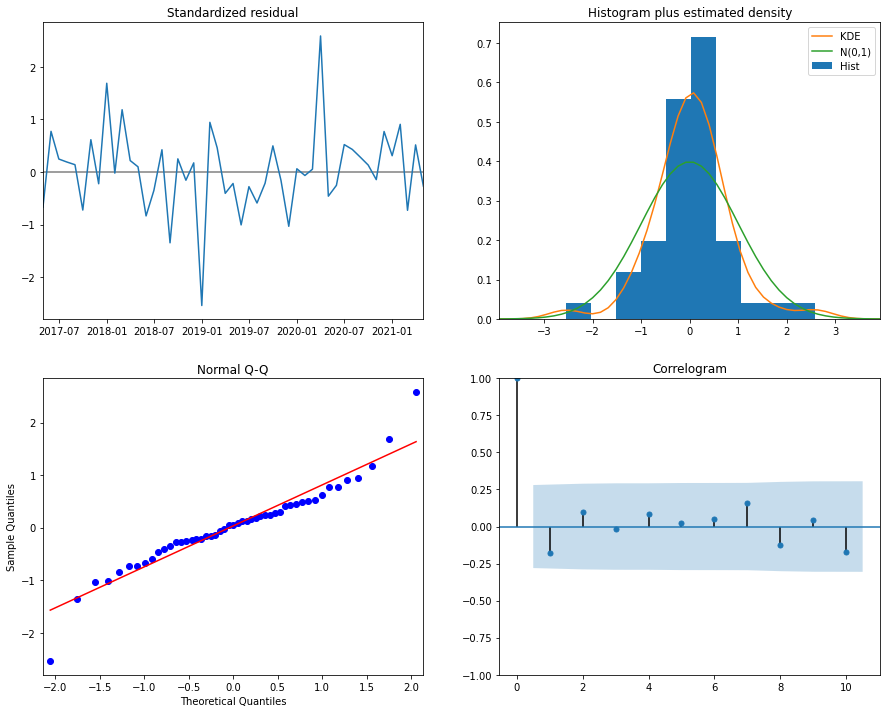



SARIMA Model Result for Zip_Code :  94041
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9694      0.024     41.186      0.000       0.923       1.016
ma.L1         -0.8702      0.068    -12.760      0.000      -1.004      -0.737
ma.S.L12      -0.5228      0.208     -2.516      0.012      -0.930      -0.115
sigma2      1.818e+11   4.25e-13   4.28e+23      0.000    1.82e+11    1.82e+11
Results of Dickey-Fuller Test:
Test Statistic                 -7.187
p-value                         0.000
#Lags Used                      2.000
Number of Observations Used    57.000
Critical Value (1%)            -3.551
Critical Value (5%)            -2.914
Critical Value (10%)           -2.595
dtype: float64


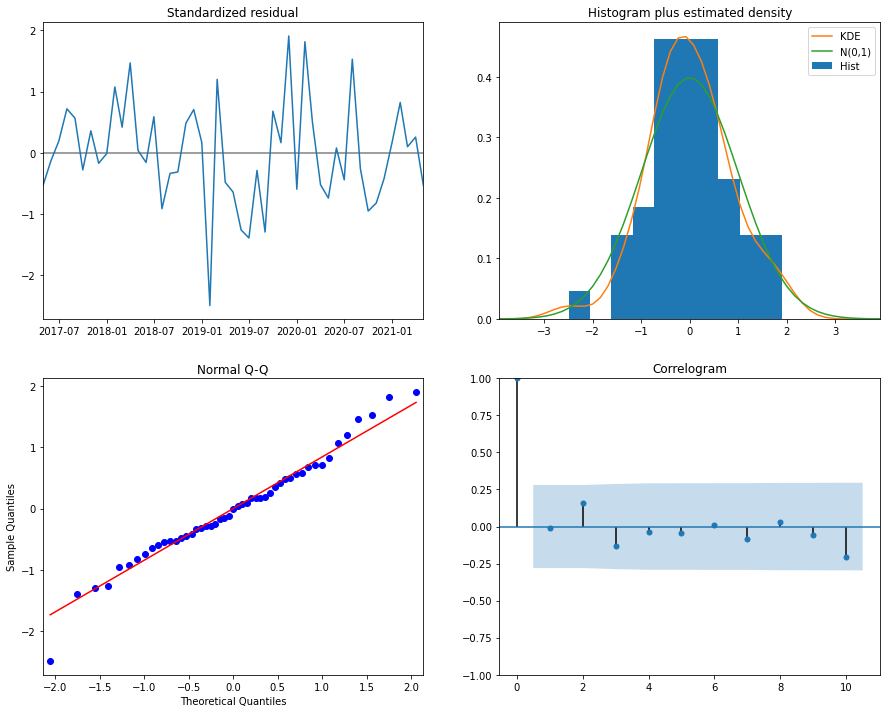



SARIMA Model Result for Zip_Code :  94043
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9628      0.015     62.363      0.000       0.933       0.993
ma.L1         -0.8638      0.029    -30.113      0.000      -0.920      -0.808
ma.S.L12      -0.4458      0.145     -3.083      0.002      -0.729      -0.162
sigma2      2.256e+10   3.91e-13   5.77e+22      0.000    2.26e+10    2.26e+10
Results of Dickey-Fuller Test:
Test Statistic                 -9.137
p-value                         0.000
#Lags Used                      1.000
Number of Observations Used    58.000
Critical Value (1%)            -3.548
Critical Value (5%)            -2.913
Critical Value (10%)           -2.594
dtype: float64


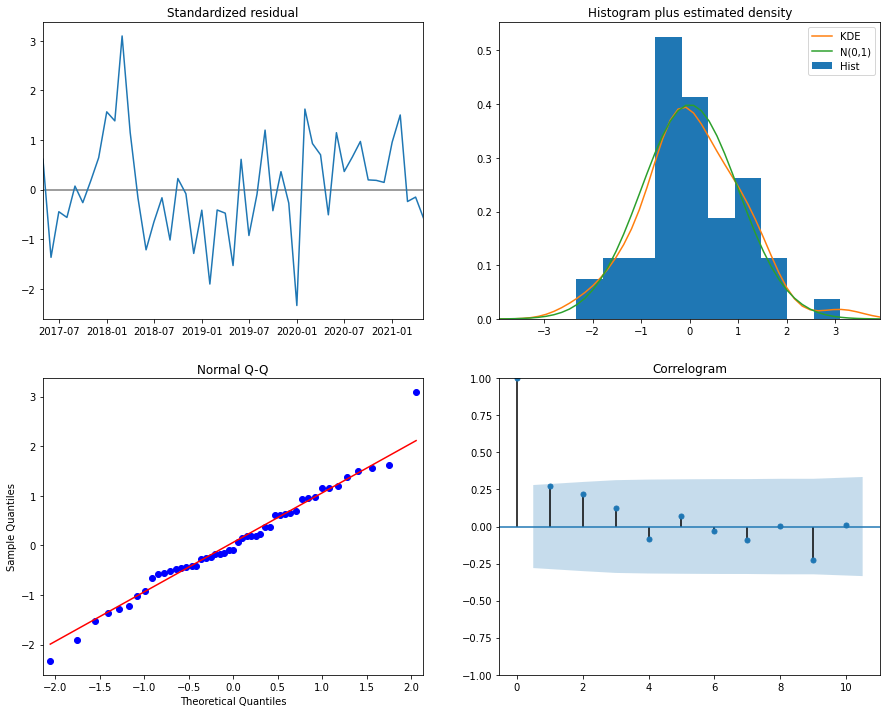



SARIMA Model Result for Zip_Code :  94085
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9936      0.026     38.661      0.000       0.943       1.044
ma.L1         -0.9039      0.033    -27.006      0.000      -0.969      -0.838
ar.S.L12       0.4169      0.196      2.131      0.033       0.034       0.800
ma.S.L12      -0.9142      0.301     -3.040      0.002      -1.504      -0.325
sigma2       2.16e+10    1.8e-11    1.2e+21      0.000    2.16e+10    2.16e+10
Results of Dickey-Fuller Test:
Test Statistic                 -7.121
p-value                         0.000
#Lags Used                      1.000
Number of Observations Used    58.000
Critical Value (1%)            -3.548
Critical Value (5%)            -2.913
Critical Value (10%)           -2.594
dtype: float64


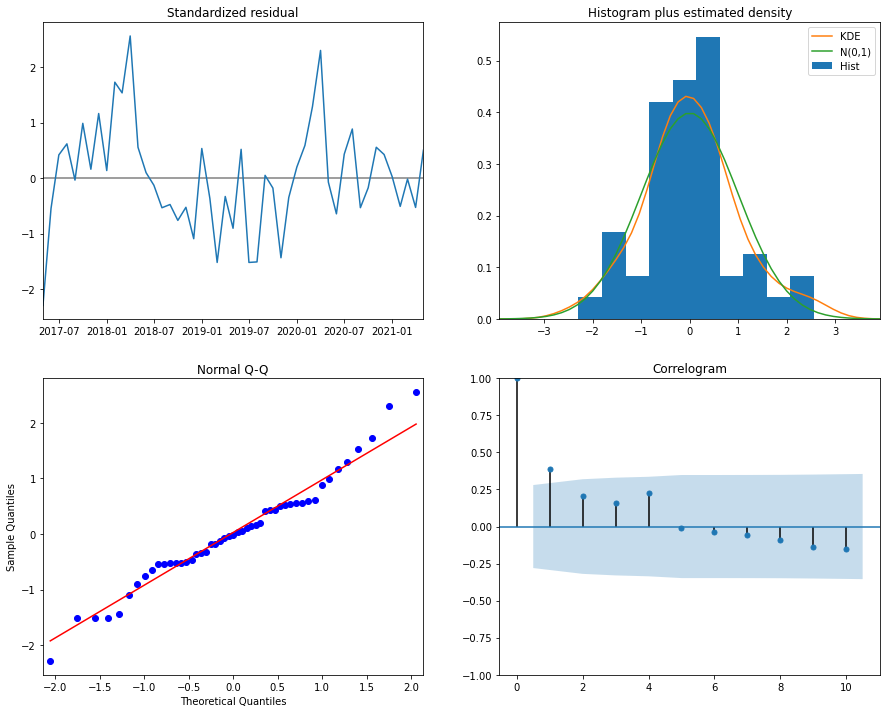



SARIMA Model Result for Zip_Code :  94086
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9168      0.038     24.339      0.000       0.843       0.991
ma.L1         -0.7965      0.055    -14.369      0.000      -0.905      -0.688
ma.S.L12      -0.2042      0.129     -1.588      0.112      -0.456       0.048
sigma2      2.909e+10   8.08e-14    3.6e+23      0.000    2.91e+10    2.91e+10
Results of Dickey-Fuller Test:
Test Statistic                -13.518
p-value                         0.000
#Lags Used                      0.000
Number of Observations Used    59.000
Critical Value (1%)            -3.546
Critical Value (5%)            -2.912
Critical Value (10%)           -2.594
dtype: float64


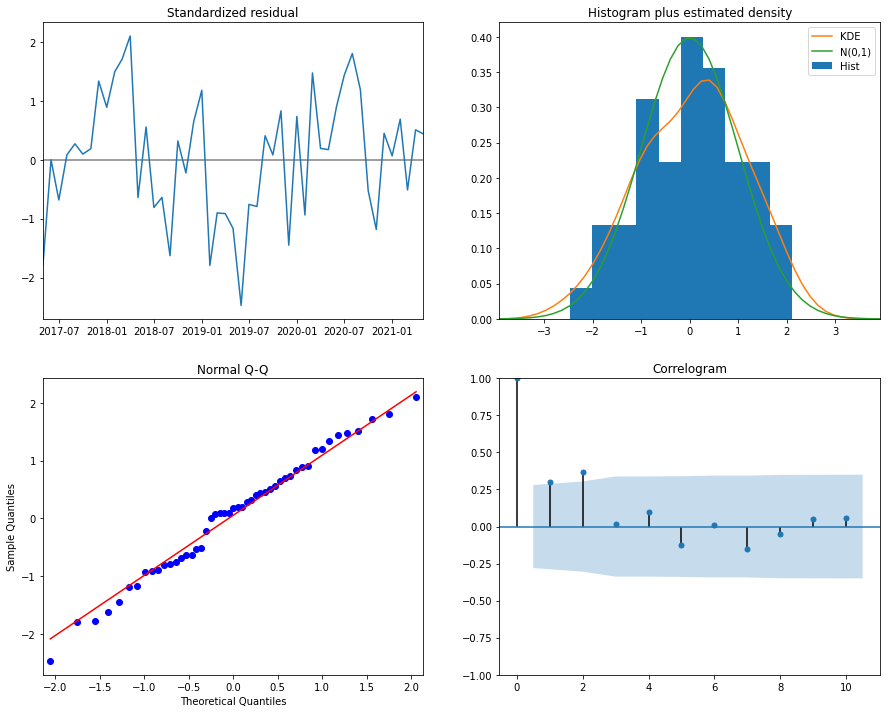



SARIMA Model Result for Zip_Code :  94087
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4865      0.274      1.775      0.076      -0.051       1.024
ma.L1          0.0461      0.408      0.113      0.910      -0.753       0.845
ma.S.L12       1.8106      0.267      6.778      0.000       1.287       2.334
sigma2      3.515e+10   4.55e-12   7.73e+21      0.000    3.52e+10    3.52e+10
Results of Dickey-Fuller Test:
Test Statistic                 -7.361
p-value                         0.000
#Lags Used                      1.000
Number of Observations Used    58.000
Critical Value (1%)            -3.548
Critical Value (5%)            -2.913
Critical Value (10%)           -2.594
dtype: float64


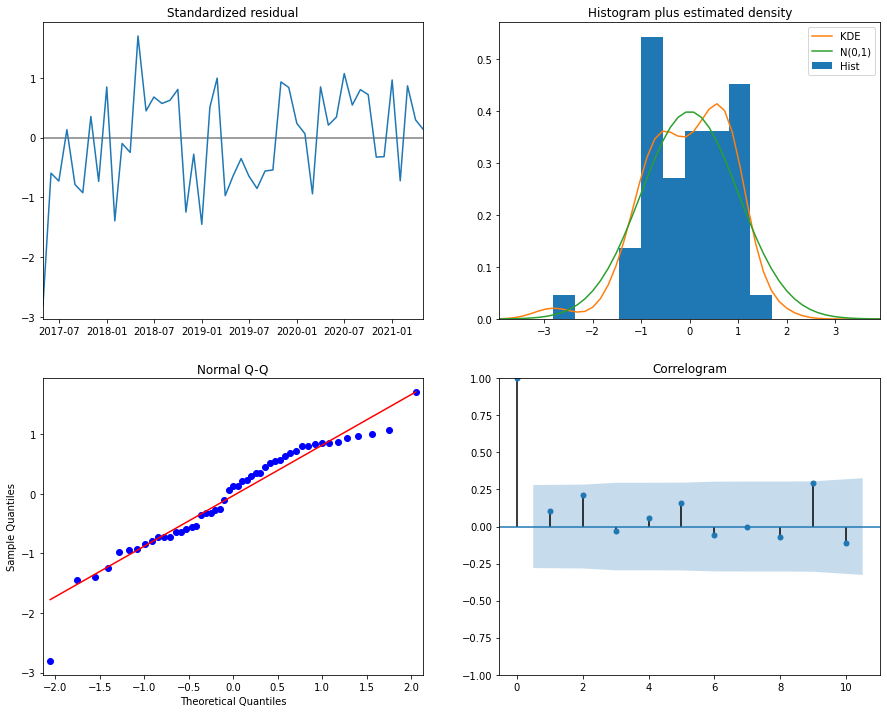



SARIMA Model Result for Zip_Code :  94089
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9893      0.041     24.327      0.000       0.910       1.069
ma.L1         -0.8797      0.048    -18.154      0.000      -0.975      -0.785
ar.S.L12       0.3298      0.186      1.775      0.076      -0.034       0.694
ma.S.L12      -0.8766      0.466     -1.882      0.060      -1.790       0.036
sigma2      2.513e+10   2.68e-11   9.38e+20      0.000    2.51e+10    2.51e+10
Results of Dickey-Fuller Test:
Test Statistic                -12.969
p-value                         0.000
#Lags Used                      0.000
Number of Observations Used    59.000
Critical Value (1%)            -3.546
Critical Value (5%)            -2.912
Critical Value (10%)           -2.594
dtype: float64


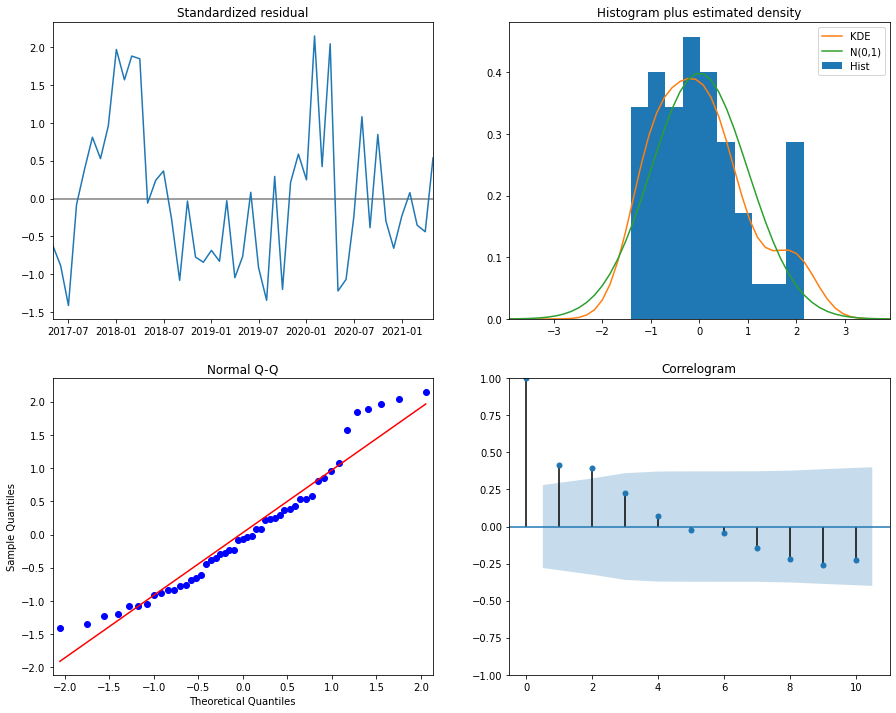



SARIMA Model Result for Zip_Code :  95014
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9237      0.047     19.482      0.000       0.831       1.017
ma.L1         -0.8884      0.074    -11.944      0.000      -1.034      -0.743
ar.S.L12      -0.9780      0.347     -2.816      0.005      -1.659      -0.297
ma.S.L12       0.9376      0.569      1.649      0.099      -0.177       2.052
sigma2      6.391e+10   1.11e-11   5.73e+21      0.000    6.39e+10    6.39e+10
Results of Dickey-Fuller Test:
Test Statistic                 -6.789
p-value                         0.000
#Lags Used                      2.000
Number of Observations Used    57.000
Critical Value (1%)            -3.551
Critical Value (5%)            -2.914
Critical Value (10%)           -2.595
dtype: float64


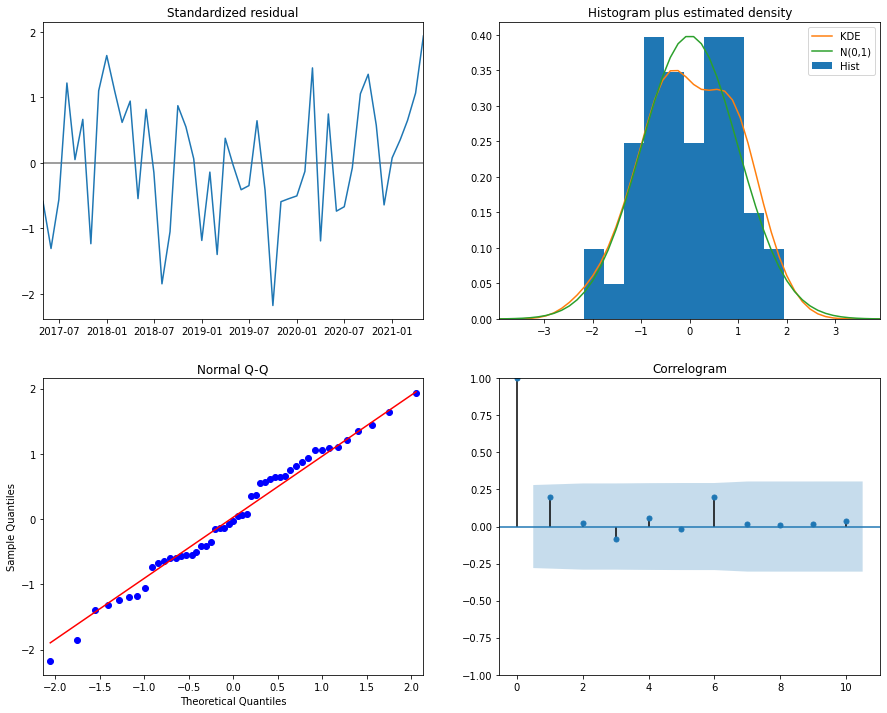



SARIMA Model Result for Zip_Code :  95050
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9737      0.022     44.278      0.000       0.931       1.017
ma.L1         -0.8332      0.047    -17.631      0.000      -0.926      -0.741
ma.S.L12      -0.6042      0.214     -2.818      0.005      -1.024      -0.184
sigma2      2.536e+10   1.09e-12   2.32e+22      0.000    2.54e+10    2.54e+10
Results of Dickey-Fuller Test:
Test Statistic                -12.431
p-value                         0.000
#Lags Used                      0.000
Number of Observations Used    59.000
Critical Value (1%)            -3.546
Critical Value (5%)            -2.912
Critical Value (10%)           -2.594
dtype: float64


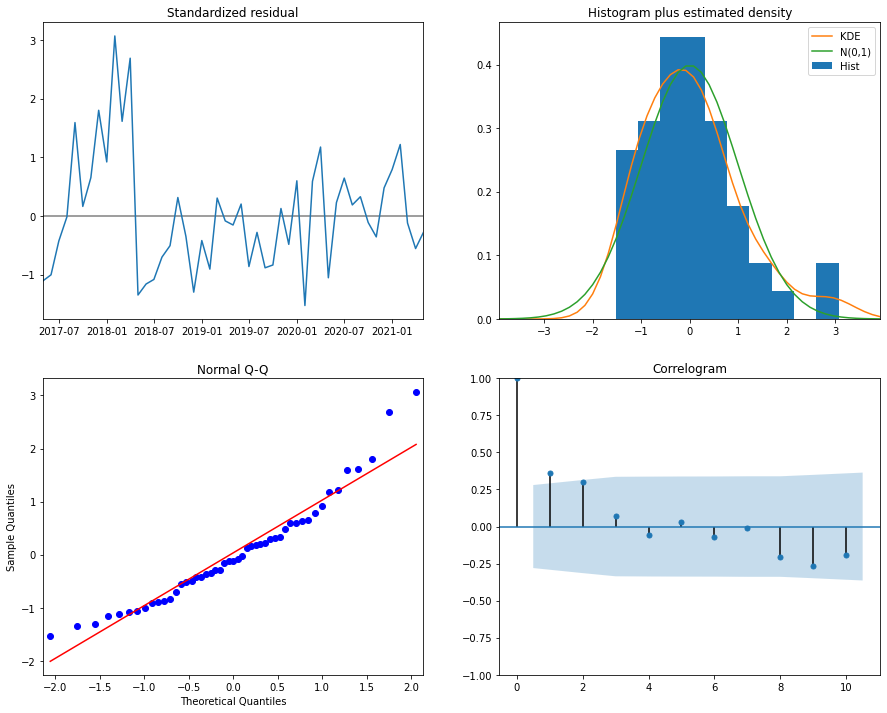



SARIMA Model Result for Zip_Code :  95051
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1247      0.362     -0.345      0.730      -0.834       0.584
ma.L1         -0.2999      0.367     -0.818      0.413      -1.018       0.419
ar.S.L12      -0.2457      0.052     -4.765      0.000      -0.347      -0.145
sigma2      1.993e+10   1.39e-11   1.43e+21      0.000    1.99e+10    1.99e+10
Results of Dickey-Fuller Test:
Test Statistic                 -6.394
p-value                         0.000
#Lags Used                      4.000
Number of Observations Used    54.000
Critical Value (1%)            -3.558
Critical Value (5%)            -2.917
Critical Value (10%)           -2.596
dtype: float64


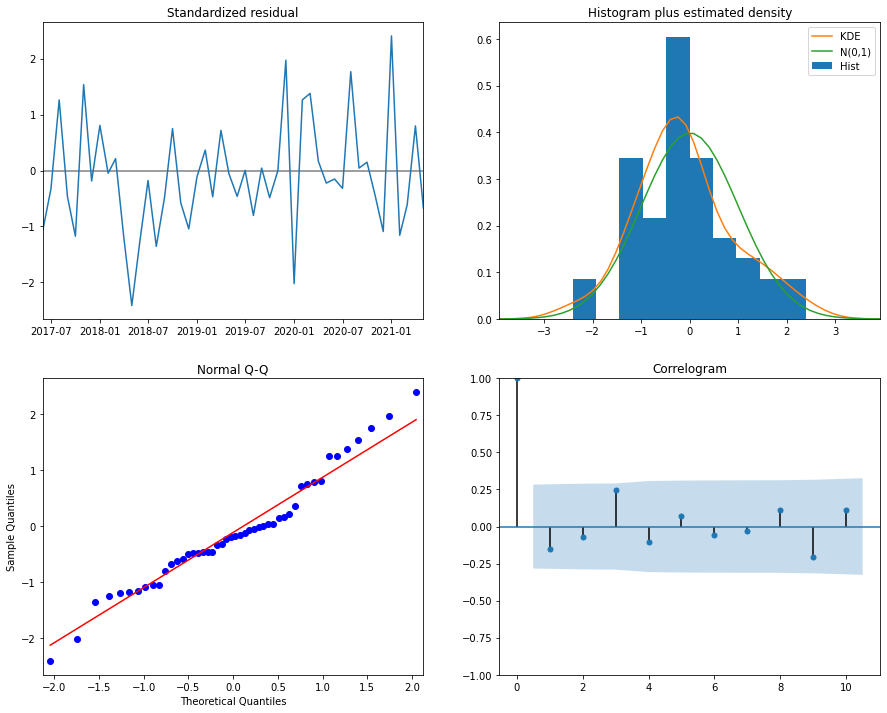



SARIMA Model Result for Zip_Code :  95054
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9823      0.027     36.037      0.000       0.929       1.036
ma.L1         -0.8436      0.073    -11.556      0.000      -0.987      -0.700
ma.S.L12      -0.6892      0.355     -1.942      0.052      -1.385       0.006
sigma2      4.555e+10   4.45e-13   1.02e+23      0.000    4.56e+10    4.56e+10
Results of Dickey-Fuller Test:
Test Statistic                 -8.944
p-value                         0.000
#Lags Used                      1.000
Number of Observations Used    58.000
Critical Value (1%)            -3.548
Critical Value (5%)            -2.913
Critical Value (10%)           -2.594
dtype: float64


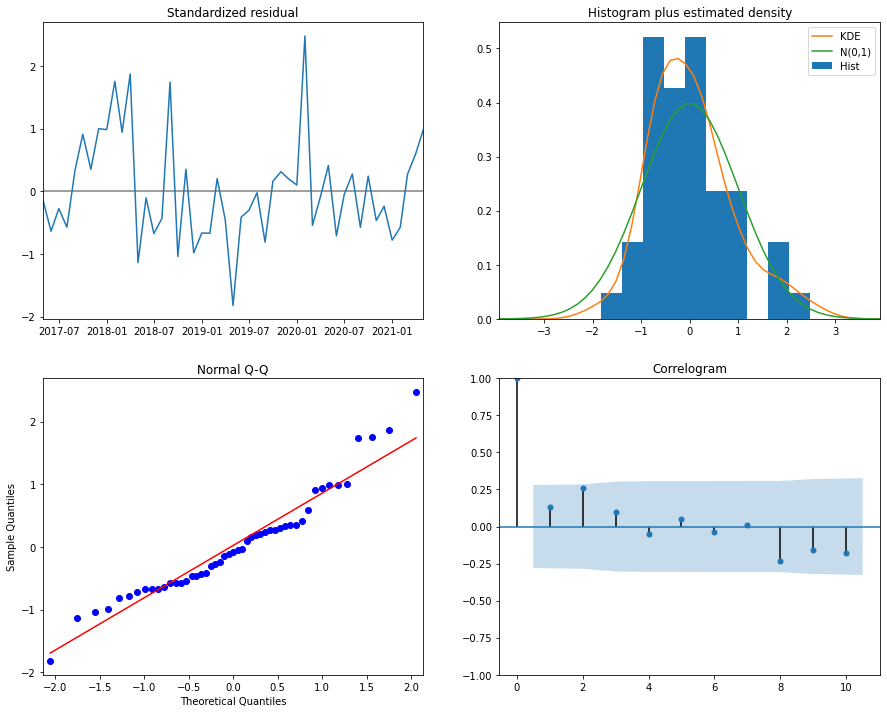

In [ ]:
t1 = evaluation(best_para, 'Zip_Code', zip_dfs)

In [ ]:
#Alternative ways to tune the paramaters

# from pmdarima.arima import auto_arima

# step_wise_collection = []

# for df, Zip_Code in zip(zip_dfs, zip_list):
#   print(Zip_Code)
#   step_wise=auto_arima(df, start_p=0, start_q=0, max_p=7, max_q=7, d=1, max_d=7, 
#                        start_P = 0, start_Q = 0, max_P = 7, max_Q = 7, D=1, max_D=7,
#                        trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
#   print(step_wise)
#   step_wise_collection.append(step_wise.order)
#   print('\n')

#### Model building and testing

In [ ]:
#Make Prediction and compare with real values

def Arima_Model(best_para, parameter_to_evaluate, zip_dfs):
  summary_table = pd.DataFrame()
  Zipcode = []
  RMSE_Value = []
  MAPE_Value = []
  models = []
  for Zip_Code, pdq, pdqs, df in zip(best_para[parameter_to_evaluate], best_para['pdq'], best_para['pdqs'], zip_dfs):

      print('\n')
      print(parameter_to_evaluate,': ', Zip_Code)
      # #Use 80% for training and 20% for testing
      # train = df[:round(len(df)*0.8)]
      # test = df[round(len(df)*0.2):]
      print(pdq, pdqs)
      ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                  order = pdq,
                                  seasonal_order = pdqs,
                                  enforce_stationarity = False,
                                  enforce_invertibility = False)
                                  
      output = ARIMA_MODEL.fit()
      models.append(output)
      print("Model AIC: ",round(output.aic,2))
      
      #get dynamic predictions starting 2020-05-01, i.e. 20% of the time series
      pred_dynamic = output.get_prediction(start=df.iloc[round(len(df)*0.8)-1].name, dynamic = True, full_results = True)
      pred_dynamic_conf = pred_dynamic.conf_int()
      zip_forecasted = pred_dynamic.predicted_mean
      zip_truth = df[df.iloc[round(len(df)*0.8)-1].name:]['PRICE']
      
      #Plot the dynamic forecast with confidence intervals as above
      ax = df.plot(label='observed', figsize=(15, 6))
      pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

      ax.fill_between(pred_dynamic_conf.index,
                      pred_dynamic_conf.iloc[:, 0],
                      pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

      ax.fill_betweenx(ax.get_ylim(), df.iloc[round(len(df)*0.8)-1].name, zip_forecasted.index[-1], alpha=.1, zorder=-1)

      ax.set_xlabel('Date')
      ax.set_ylabel('Average House Price')
      plt.title(Zip_Code)

      plt.legend()
      plt.show()

      #print(type(zip_forecasted))
      #print(zip_truth)
      sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
      print('The Root Mean Squared Error of our forecasts for {} is {}'.format(Zip_Code,round(sqrt_mse, 2))) 
      
      Zipcode.append(Zip_Code)
      RMSE_Value.append(sqrt_mse)
      
  summary_table[parameter_to_evaluate] = Zipcode
  summary_table['RMSE'] = RMSE_Value
  summary_table['Model'] = models
  return summary_table
      



Zip_Code :  94040
(1, 0, 1) (0, 1, 1, 12)
Model AIC:  1008.58


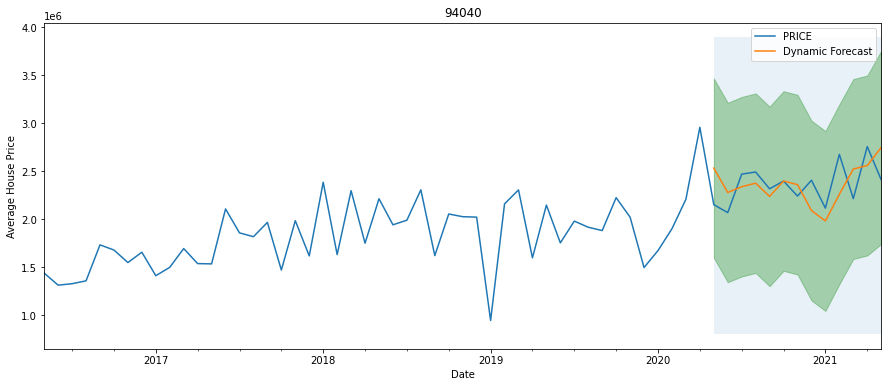

The Root Mean Squared Error of our forecasts for 94040 is 244803.46


Zip_Code :  94041
(1, 0, 1) (0, 1, 1, 12)
Model AIC:  1008.62


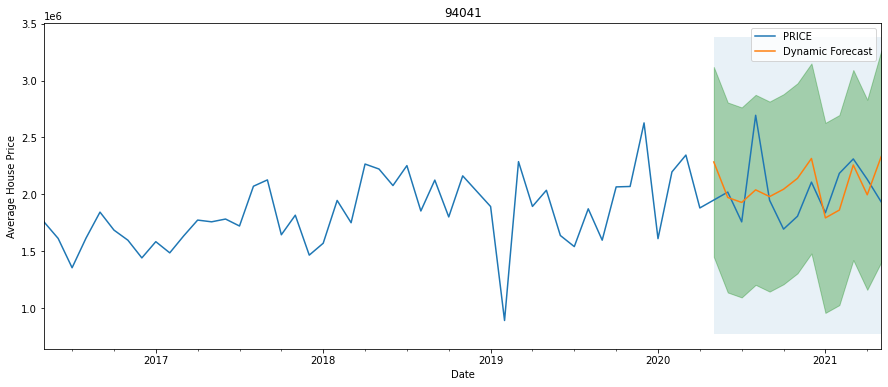

The Root Mean Squared Error of our forecasts for 94041 is 296006.89


Zip_Code :  94043
(1, 0, 1) (0, 1, 1, 12)
Model AIC:  935.13


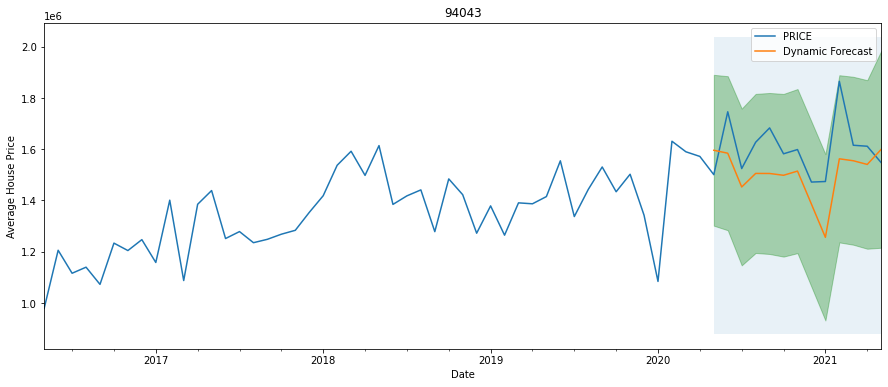

The Root Mean Squared Error of our forecasts for 94043 is 141093.76


Zip_Code :  94085
(1, 0, 1) (1, 1, 1, 12)
Model AIC:  923.94


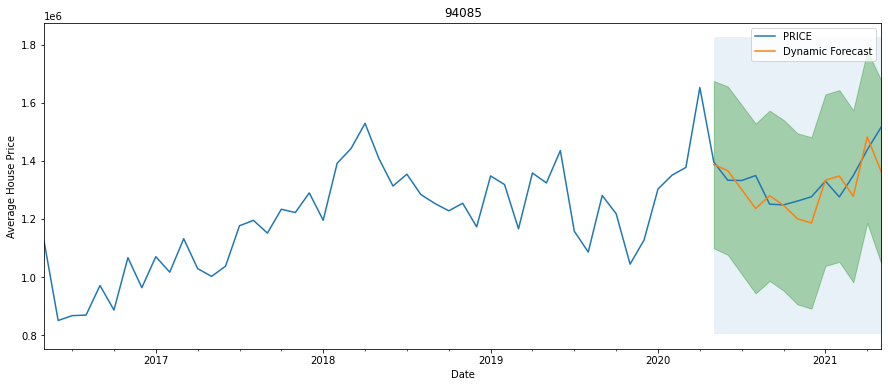

The Root Mean Squared Error of our forecasts for 94085 is 70016.54


Zip_Code :  94086
(1, 0, 1) (0, 1, 1, 12)
Model AIC:  945.55


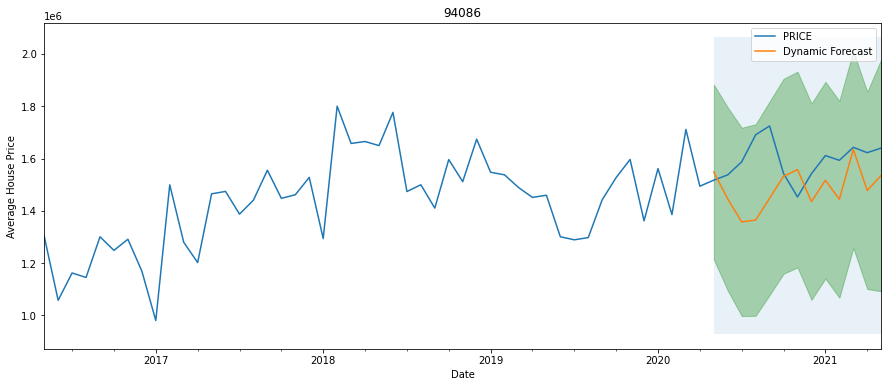

The Root Mean Squared Error of our forecasts for 94086 is 159368.95


Zip_Code :  94087
(1, 0, 1) (0, 1, 1, 12)
Model AIC:  945.19


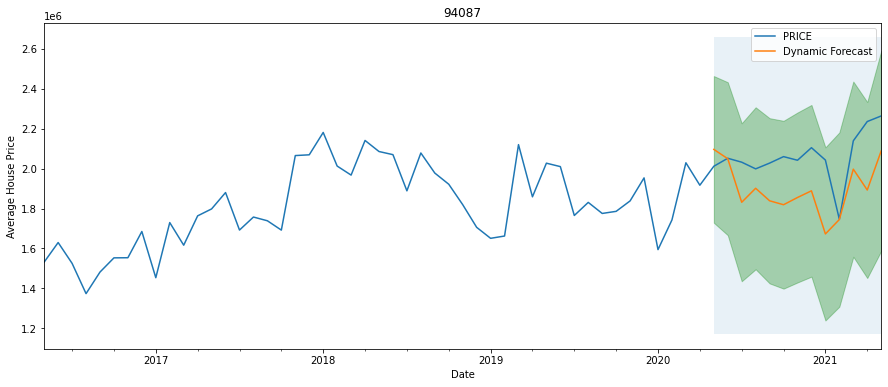

The Root Mean Squared Error of our forecasts for 94087 is 203399.91


Zip_Code :  94089
(1, 0, 1) (1, 1, 1, 12)
Model AIC:  926.58


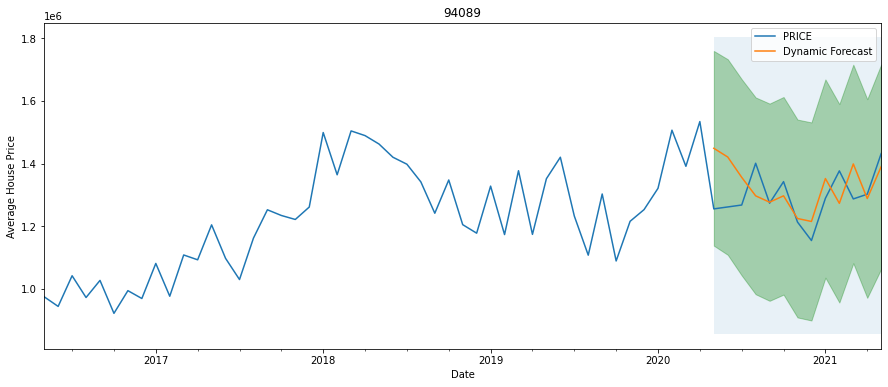

The Root Mean Squared Error of our forecasts for 94089 is 94627.09


Zip_Code :  95014
(1, 0, 1) (1, 1, 1, 12)
Model AIC:  969.39


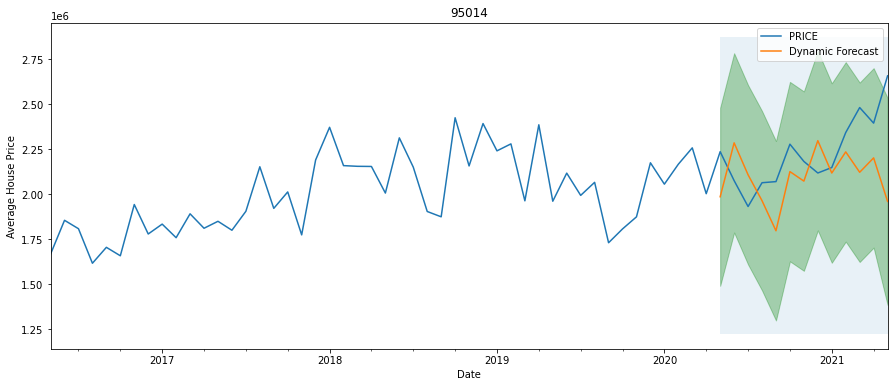

The Root Mean Squared Error of our forecasts for 95014 is 271443.57


Zip_Code :  95050
(1, 0, 1) (0, 1, 1, 12)
Model AIC:  925.69


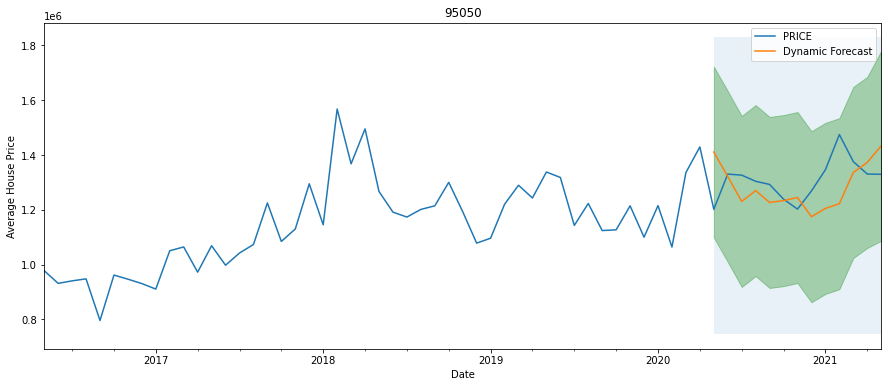

The Root Mean Squared Error of our forecasts for 95050 is 113269.45


Zip_Code :  95051
(1, 1, 1) (1, 1, 0, 12)
Model AIC:  924.77


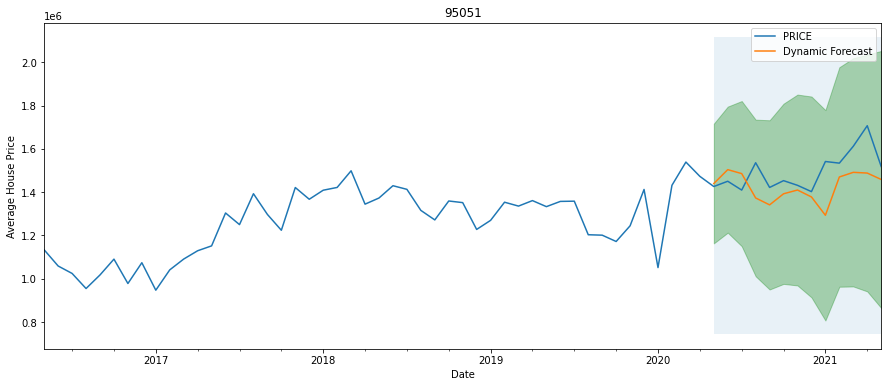

The Root Mean Squared Error of our forecasts for 95051 is 117217.18


Zip_Code :  95054
(1, 0, 1) (0, 1, 1, 12)
Model AIC:  954.13


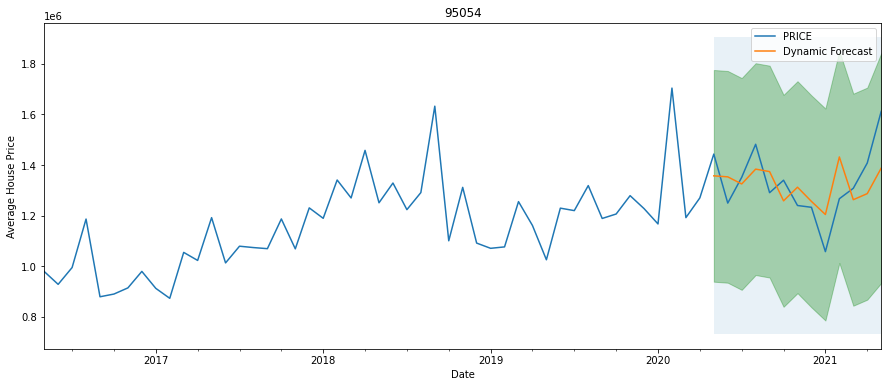

The Root Mean Squared Error of our forecasts for 95054 is 112201.91


In [ ]:
summary_table_Zip = Arima_Model(best_para, 'Zip_Code', zip_dfs)

#### Forecast

In [ ]:
#Final Model 

def ModelForecast(parameter_to_evaluate, summary_table, zip_dfs ,freq):
  forecast_table = pd.DataFrame()
  current = []

  #1 year forecast
  forecast_1Yr = []
  conf_1Yr_L=[]
  conf_1Yr_U=[]

  #3 year forecast
  forecast_3Yr = []
  conf_3Yr_L=[]
  conf_3Yr_U=[]

  #5 year forecast
  forecast_5Yr =[]
  conf_5Yr_L=[]
  conf_5Yr_U=[]


  for zip_code, output, df in zip(summary_table[parameter_to_evaluate], summary_table['Model'], zip_dfs):
    
    #Record the current price
    current.append(df.tail(1)['PRICE'][0])  

    #1 year forecast  
    pred_1 = output.get_forecast(steps = freq) #12 months  
    pred_conf_1 = pred_1.conf_int()
    forecast_1 = pred_1.predicted_mean.to_numpy()[-1] #only need the last item
    
    forecast_1Yr.append(forecast_1)
    conf_1Yr_L.append(pred_conf_1.iloc[:, 0][-1])
    conf_1Yr_U.append(pred_conf_1.iloc[:, 1][-1])

    #3 year forecast  
    pred_3 = output.get_forecast(steps = freq*3) #36 months  
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1] #only need the last item
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append(pred_conf_3.iloc[:, 0][-1])
    conf_3Yr_U.append(pred_conf_3.iloc[:, 1][-1])

    #5 year forecast  
    pred_5 = output.get_forecast(steps = freq*5)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]  

    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])
    
    # #auto corr plot
    # res = output.resid
    # fig,ax = plt.subplots(2,1,figsize=(15,8))
    # fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
    # fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
    # plt.show()

  #Create a cleaned table
  forecast_table[parameter_to_evaluate] = summary_table[parameter_to_evaluate]
  forecast_table['Current Value'] = current

  #1 year forecast
  forecast_table['1 Years Value'] = forecast_1Yr
  forecast_table['1 Years Lower'] = conf_1Yr_L
  forecast_table['1 Years Upper'] = conf_1Yr_U

  forecast_table['1Yr-ROI']=((forecast_table['1 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value'])*100
  forecast_table['1Yr-ROI-Lower']=((forecast_table['1 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value'])*100
  forecast_table['1Yr-ROI-Upper']=((forecast_table['1 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value'])*100

  #3 years forecast
  forecast_table['3 Years Value'] = forecast_3Yr
  forecast_table['3 Years Lower'] = conf_3Yr_L
  forecast_table['3 Years Upper'] = conf_3Yr_U

  forecast_table['3Yr-CAGR']=((forecast_table['3 Years Value']/forecast_table['Current Value'])**(1/3)- 1)*100
  forecast_table['3Yr-CAGR-Lower']=((forecast_table['3 Years Lower']/forecast_table['Current Value'])**(1/3)- 1)*100
  forecast_table['3Yr-CAGR-Upper']=((forecast_table['3 Years Upper']/forecast_table['Current Value'])**(1/3)- 1)*100

  #5 years forecast
  forecast_table['5 Years Value'] = forecast_5Yr
  forecast_table['5 Years Lower'] = conf_5Yr_L
  forecast_table['5 Years Upper'] = conf_5Yr_U

  forecast_table['5Yr-CAGR']=((forecast_table['5 Years Value']/forecast_table['Current Value'])**(1/5) - 1)*100
  forecast_table['5Yr-CAGR-Lower']=((forecast_table['5 Years Lower']/forecast_table['Current Value'])**(1/5) - 1)*100
  forecast_table['5Yr-CAGR-Upper']=((forecast_table['5 Years Upper']/forecast_table['Current Value'])**(1/5) - 1)*100
  return forecast_table

In [ ]:
forecast_table_Zip = ModelForecast('Zip_Code', summary_table_Zip, zip_dfs, 12)
forecast_table_Zip = round(forecast_table_Zip,2)
# forecast_table_Zip = round(forecast_table_Zip[forecast_table_Zip['Zip_Code']!=94041],2)
forecast_table_Zip

Zip_Code  Current Value  ...  5Yr-CAGR-Lower  5Yr-CAGR-Upper
0      94040     2411875.00  ...           -4.24           12.49
1      94041     1933050.00  ...          -13.34           11.13
2      94043     1547625.00  ...           -8.60            6.95
3      94085     1516209.78  ...           -7.76            4.81
4      94086     1640000.00  ...          -10.28            6.54
5      94087     2263882.67  ...           -8.50            5.52
6      94089     1432000.00  ...           -9.38            4.92
7      95014     2658146.08  ...           -8.94            5.42
8      95050     1329500.00  ...           -6.97            6.18
9      95051     1518449.45  ...             NaN           25.30
10     95054     1612000.00  ...           -9.27            5.30

[11 rows x 20 columns]

In [ ]:
forecast_table_Zip.sort_values(by='3Yr-CAGR', ascending= False)[['Zip_Code', '3Yr-CAGR']]

Zip_Code  3Yr-CAGR
9      95051      8.20
0      94040      7.07
1      94041      2.86
8      95050      0.69
2      94043      0.62
4      94086     -0.77
5      94087     -0.83
3      94085     -1.25
7      95014     -1.39
10     95054     -1.64
6      94089     -2.30

In [ ]:
forecast_table_Zip.sort_values(by='5Yr-CAGR',ascending= False)[['Zip_Code', '5Yr-CAGR']]

Zip_Code  5Yr-CAGR
9      95051      7.48
0      94040      5.44
1      94041      1.78
8      95050      0.46
2      94043      0.37
4      94086     -0.46
5      94087     -0.51
3      94085     -0.69
7      95014     -0.73
10     95054     -0.92
6      94089     -1.20

From our 3 year and 5 year forcasting results, the zipcode 95051 gives us the highest 3yr return on investment compare to other zipcode. For 5 year trend, the 95051 still is the top performer with highest ROI among all the places.

### Step 2.Within the highest ROI Zip Code, find the highest ROI property type

In [ ]:
highest_zipcode = forecast_table_Zip.sort_values(by='5Yr-CAGR',ascending= False)[['Zip_Code', '5Yr-CAGR']].iloc[0,0]
highest_zipcode

95051

In [ ]:
step2_df = housing.loc[housing['ZIP OR POSTAL CODE']==highest_zipcode]
step2_df = step2_df[['SOLD DATE', 'PROPERTY TYPE', 'PRICE']]
step2_df['SOLD DATE'] = pd.PeriodIndex(step2_df['SOLD DATE'], freq='Q')
# # step2_df['SOLD DATE'] = step2_df['SOLD DATE'].apply(lambda x:str(x.year)+'-Q'+str(x.quarter))
step2_df['SOLD DATE'] = step2_df['SOLD DATE'].apply(lambda x:x.to_timestamp())
step2_df2 = step2_df.groupby(['PROPERTY TYPE', 'SOLD DATE']).mean().sort_values(by = ['SOLD DATE','PROPERTY TYPE']).reset_index()
# step2_df2.head()
step2_df2.set_index('SOLD DATE', inplace = True)
step2_df2.head()

PROPERTY TYPE         PRICE
SOLD DATE                                          
2016-04-01                Condo/Co-op  6.703041e+05
2016-04-01  Single Family Residential  1.240438e+06
2016-04-01                  Townhouse  8.292000e+05
2016-07-01                Condo/Co-op  5.717195e+05
2016-07-01  Single Family Residential  1.136198e+06

In [ ]:
proType_dfs = []
proType_list = step2_df2['PROPERTY TYPE'].unique()
for x in proType_list:
  df_2 = pd.DataFrame(step2_df2[step2_df2['PROPERTY TYPE']==x][['PRICE']].copy())

  #Fill NA with moving average
  rolling = df_2['PRICE'].rolling(3,center=True,min_periods=1).mean()
  rolling_df = pd.DataFrame(rolling)
  df_2.update(rolling_df, overwrite = False)

  df_2.index = pd.DatetimeIndex(df_2.index.values, freq='QS')
  proType_dfs.append(df_2)

Plot for Condo/Co-op


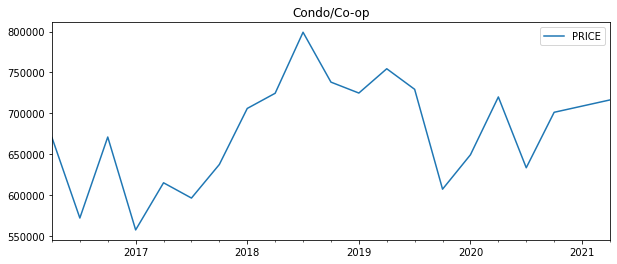

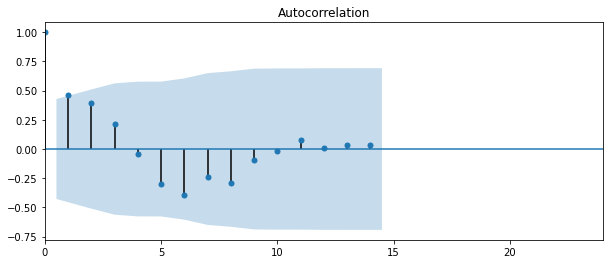

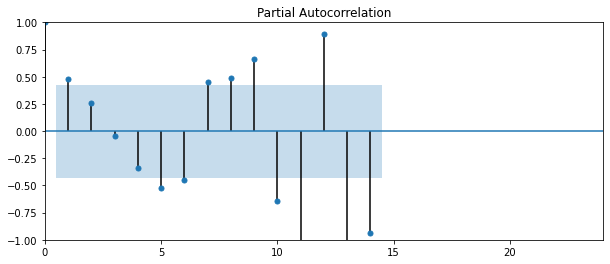

Results of Dickey-Fuller Test:
Test Statistic                 -3.220
p-value                         0.019
#Lags Used                      8.000
Number of Observations Used    12.000
Critical Value (1%)            -4.138
Critical Value (5%)            -3.155
Critical Value (10%)           -2.714
dtype: float64


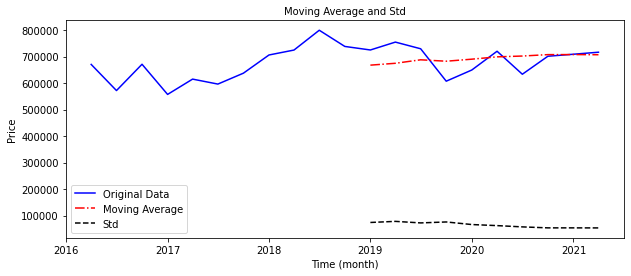

Plot for Single Family Residential


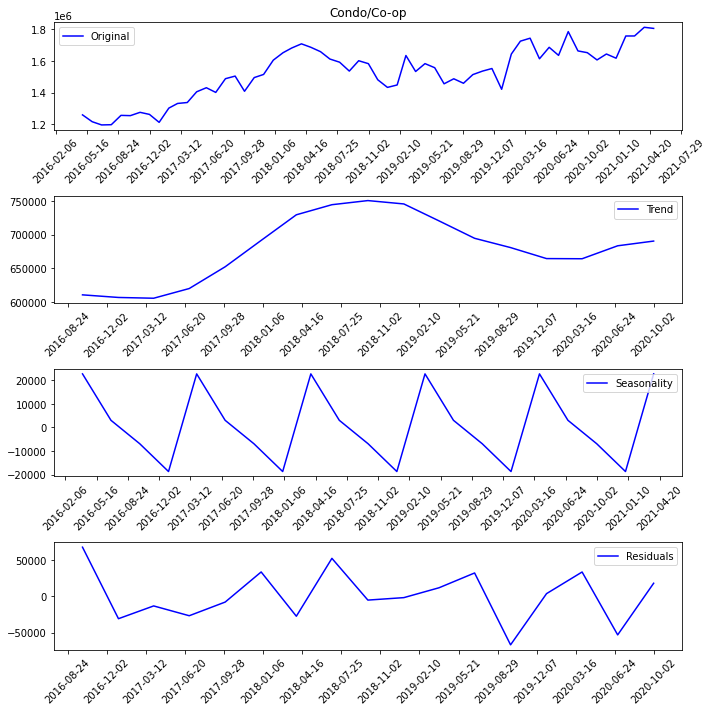

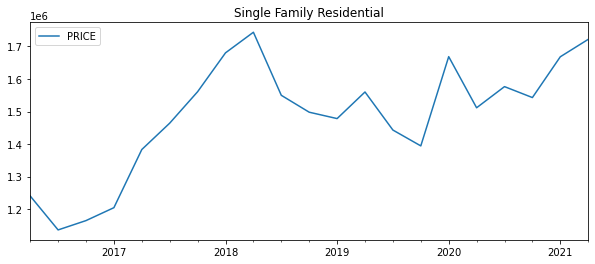

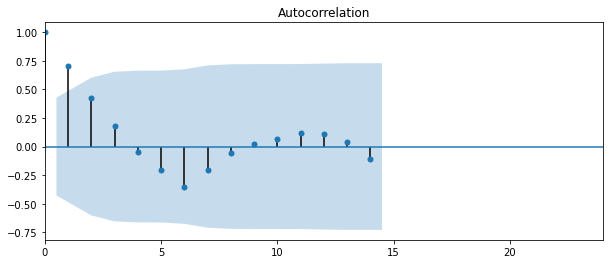

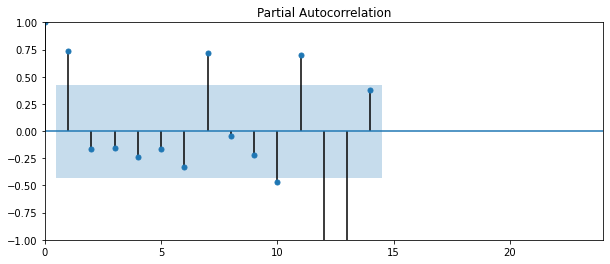

Results of Dickey-Fuller Test:
Test Statistic                 -1.927
p-value                         0.320
#Lags Used                      7.000
Number of Observations Used    13.000
Critical Value (1%)            -4.069
Critical Value (5%)            -3.127
Critical Value (10%)           -2.702
dtype: float64


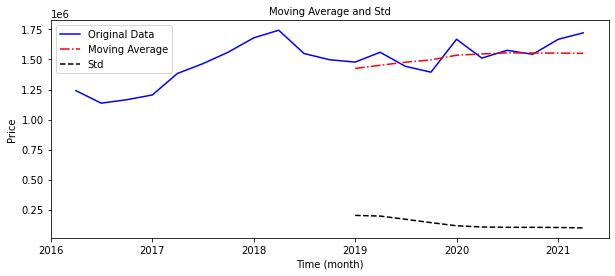

Plot for Townhouse


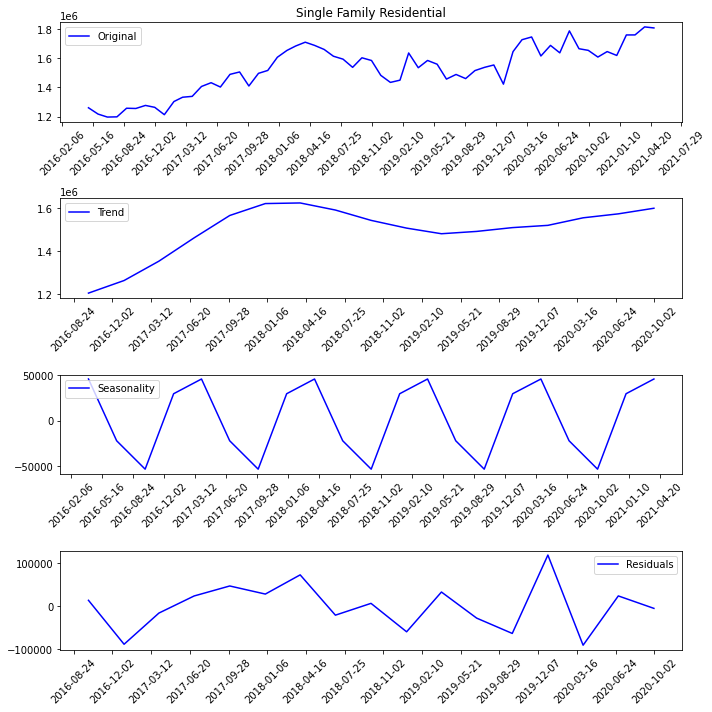

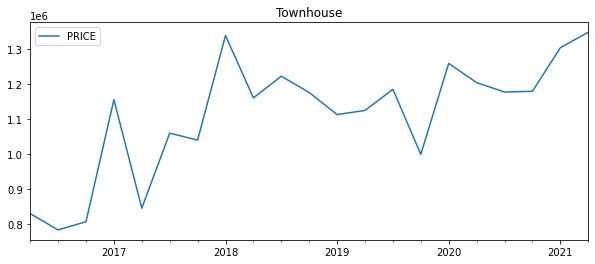

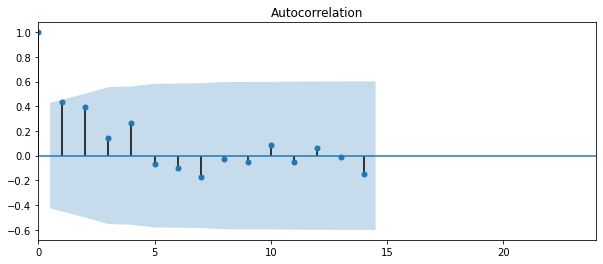

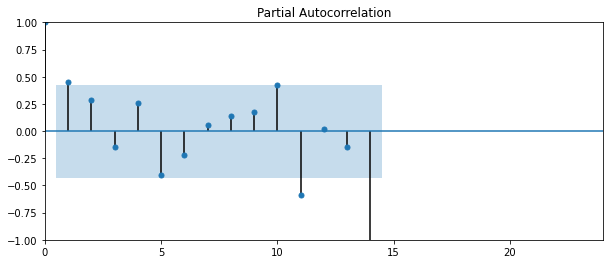

Results of Dickey-Fuller Test:
Test Statistic                 -2.564
p-value                         0.101
#Lags Used                      0.000
Number of Observations Used    20.000
Critical Value (1%)            -3.809
Critical Value (5%)            -3.022
Critical Value (10%)           -2.651
dtype: float64


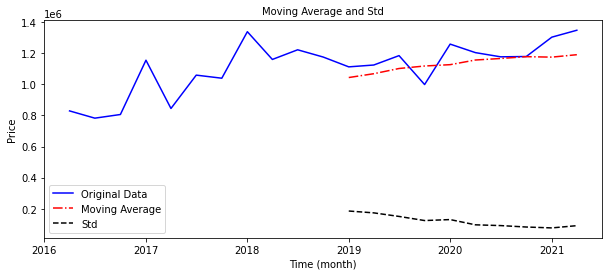

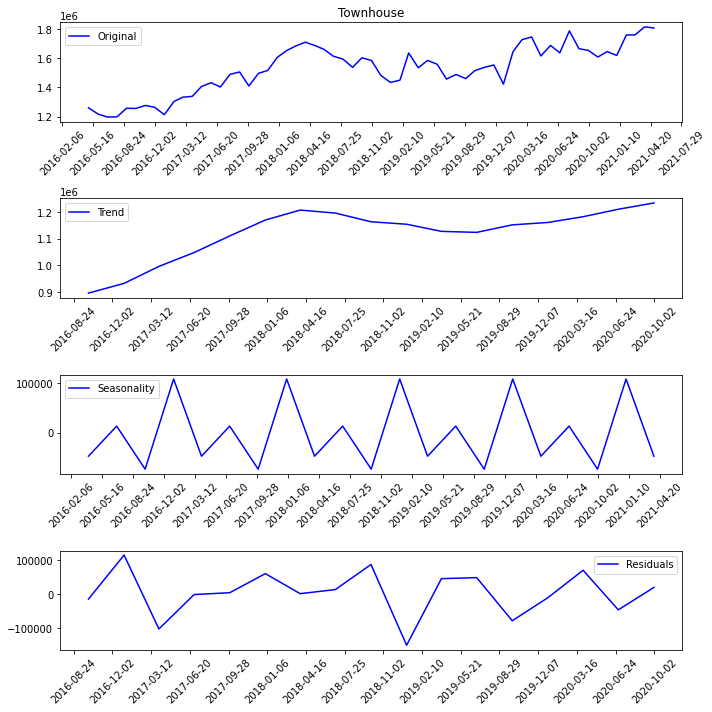

In [ ]:
multi_plot(proType_dfs, proType_list)

#### Model Tuning

In [ ]:
# Same as the zip code,  we will try every combination of p, d and q parameters where the value is 0, 1 or 2 to figure out which one can produce the best outcome in terms of lowest AIC
p1 = d1 = q1 = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq1 = list(itertools.product(p1,d1,q1))
# Generate all different combinations of seasonal p, d and q triplets
phat1 = dhat1 = qhat1 = range(0,2)
pdqs1 = [(x[0], x[1], x[2], 4) for x in list(itertools.product(phat1, dhat1, qhat1))]
# pdqs =[(0, 0, 0, 12)]
print(pdq1)
print(pdqs1)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 4), (0, 0, 1, 4), (0, 1, 0, 4), (0, 1, 1, 4), (1, 0, 0, 4), (1, 0, 1, 4), (1, 1, 0, 4), (1, 1, 1, 4)]


In [ ]:
tuning_ans_step2 = ModelTuning(proType_dfs, proType_list, pdq1, pdqs1)

Result for Condo/Co-op ARIMA (0, 0, 0) x (0, 0, 0, 4) : AIC Calculated = 596.0142343036007
Result for Condo/Co-op ARIMA (0, 0, 0) x (0, 0, 1, 4) : AIC Calculated = 469.75692393414226
Result for Condo/Co-op ARIMA (0, 0, 0) x (0, 1, 0, 4) : AIC Calculated = 414.13060722080326
Result for Condo/Co-op ARIMA (0, 0, 0) x (0, 1, 1, 4) : AIC Calculated = 316.9970429860588
Result for Condo/Co-op ARIMA (0, 0, 0) x (1, 0, 0, 4) : AIC Calculated = 440.4482606478775
Result for Condo/Co-op ARIMA (0, 0, 0) x (1, 0, 1, 4) : AIC Calculated = 421.2512535729848
Result for Condo/Co-op ARIMA (0, 0, 0) x (1, 1, 0, 4) : AIC Calculated = 337.21998972672634
Result for Condo/Co-op ARIMA (0, 0, 0) x (1, 1, 1, 4) : AIC Calculated = 324.24774595752706
Result for Condo/Co-op ARIMA (0, 0, 1) x (0, 0, 0, 4) : AIC Calculated = 555.2763644734869
Result for Condo/Co-op ARIMA (0, 0, 1) x (0, 0, 1, 4) : AIC Calculated = 439.02446793382825
Result for Condo/Co-op ARIMA (0, 0, 1) x (0, 1, 0, 4) : AIC Calculated = 388.29585275

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Result for Condo/Co-op ARIMA (1, 0, 1) x (1, 0, 1, 4) : AIC Calculated = 372.1837802293661
Result for Condo/Co-op ARIMA (1, 0, 1) x (1, 1, 0, 4) : AIC Calculated = 307.8376696741391
Result for Condo/Co-op ARIMA (1, 0, 1) x (1, 1, 1, 4) : AIC Calculated = 282.44706341086794
Result for Condo/Co-op ARIMA (1, 1, 0) x (0, 0, 0, 4) : AIC Calculated = 473.6709456916933
Result for Condo/Co-op ARIMA (1, 1, 0) x (0, 0, 1, 4) : AIC Calculated = 377.16506398104815
Result for Condo/Co-op ARIMA (1, 1, 0) x (0, 1, 0, 4) : AIC Calculated = 387.80459814723577
Result for Condo/Co-op ARIMA (1, 1, 0) x (0, 1, 1, 4) : AIC Calculated = 999.1837032974728
Result for Condo/Co-op ARIMA (1, 1, 0) x (1, 0, 0, 4) : AIC Calculated = 377.2422606317888
Result for Condo/Co-op ARIMA (1, 1, 0) x (1, 0, 1, 4) : AIC Calculated = 372.88659663073497
Result for Condo/Co-op ARIMA (1, 1, 0) x (1, 1, 0, 4) : AIC Calculated = 284.3379968772724
Result for Condo/Co-op ARIMA (1, 1, 0) x (1, 1, 1, 4) : AIC Calculated = 1006.48786460

In [ ]:
result_step2 = pd.DataFrame(tuning_ans_step2, columns = ['Property_Type','pdq','pdqs','AIC']).sort_values(by = ['AIC'])
best_para_step2 = result_step2.loc[result_step2.groupby("Property_Type")["AIC"].idxmin()]
best_para_step2

Property_Type        pdq          pdqs         AIC
11                 Condo/Co-op  (0, 0, 1)  (0, 1, 1, 4)  280.173035
75   Single Family Residential  (0, 0, 1)  (0, 1, 1, 4)  295.236537
171                  Townhouse  (1, 0, 1)  (0, 1, 1, 4)  293.323906



SARIMA Model Result for Property_Type :  Condo/Co-op
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4504      0.597      0.755      0.450      -0.719       1.620
ma.S.L4       -2.1461      0.433     -4.959      0.000      -2.994      -1.298
sigma2      6.228e+09   5.03e-11   1.24e+20      0.000    6.23e+09    6.23e+09
Results of Dickey-Fuller Test:
Test Statistic                 -2.253
p-value                         0.188
#Lags Used                      7.000
Number of Observations Used    12.000
Critical Value (1%)            -4.138
Critical Value (5%)            -3.155
Critical Value (10%)           -2.714
dtype: float64


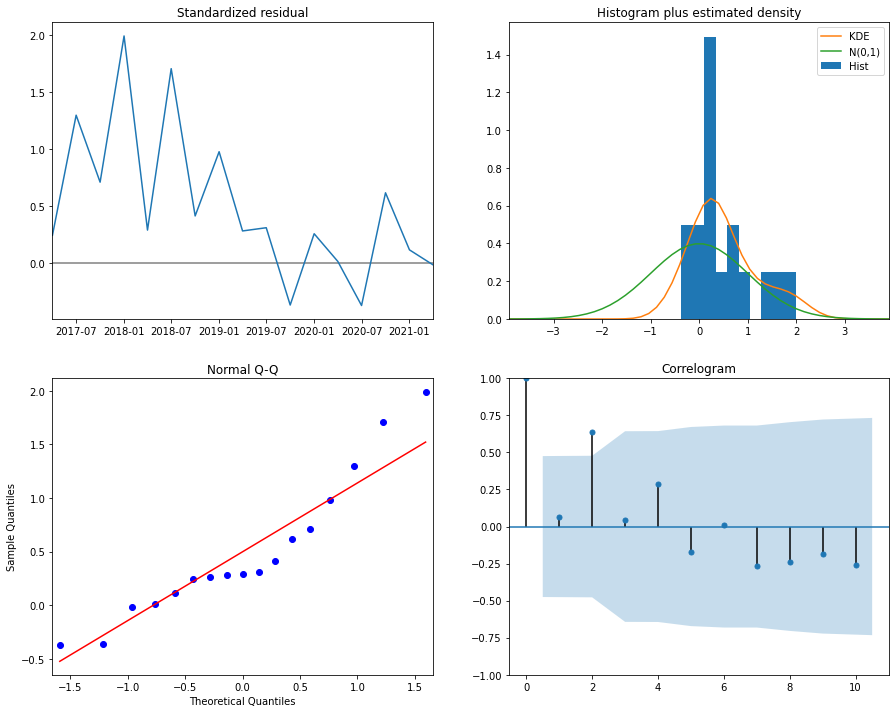



SARIMA Model Result for Property_Type :  Single Family Residential
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1102      0.129      0.856      0.392      -0.142       0.362
ma.S.L4        0.1828      0.066      2.777      0.005       0.054       0.312
sigma2      2.615e+10   6.25e-13   4.18e+22      0.000    2.62e+10    2.62e+10
Results of Dickey-Fuller Test:
Test Statistic                 -2.633
p-value                         0.086
#Lags Used                      8.000
Number of Observations Used    11.000
Critical Value (1%)            -4.223
Critical Value (5%)            -3.189
Critical Value (10%)           -2.730
dtype: float64


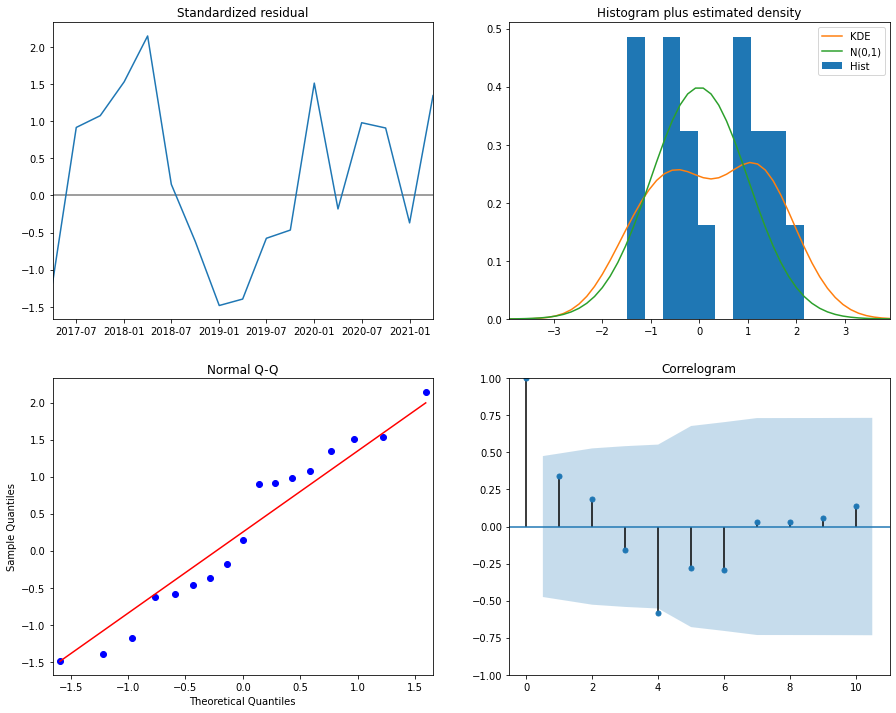



SARIMA Model Result for Property_Type :  Townhouse
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.131      7.615      0.000       0.743       1.257
ma.L1         -1.0003      0.980     -1.021      0.307      -2.921       0.921
ma.S.L4        2.0291      0.830      2.446      0.014       0.403       3.655
sigma2      1.884e+10   4.53e-11   4.16e+20      0.000    1.88e+10    1.88e+10
Results of Dickey-Fuller Test:
Test Statistic                -10.436
p-value                         0.000
#Lags Used                      8.000
Number of Observations Used    11.000
Critical Value (1%)            -4.223
Critical Value (5%)            -3.189
Critical Value (10%)           -2.730
dtype: float64


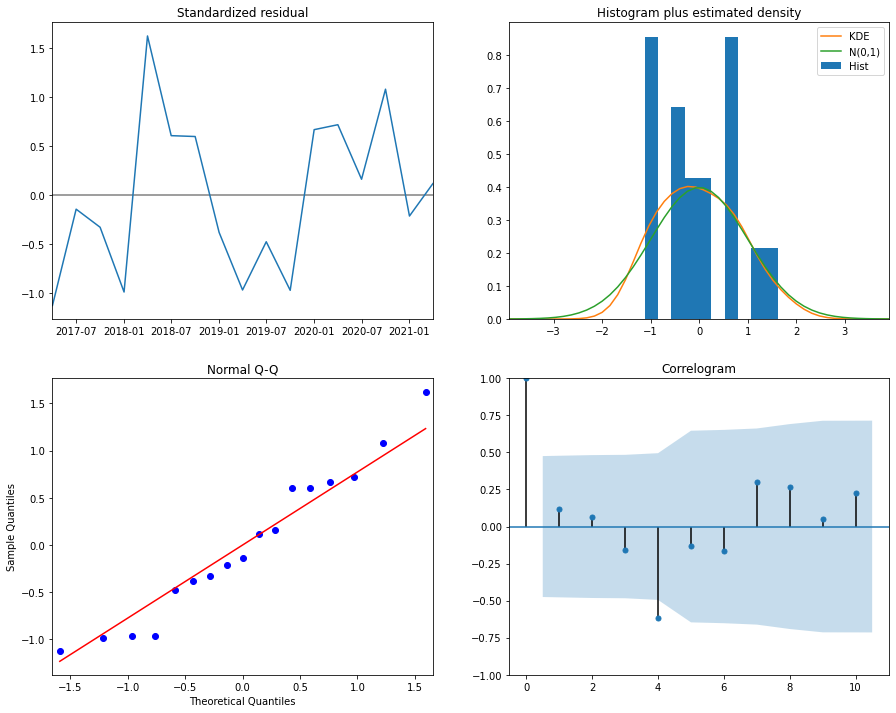

In [ ]:
evaluation(best_para_step2, 'Property_Type', proType_dfs)

#### Model building and testing



Property_Type :  Condo/Co-op
(0, 0, 1) (0, 1, 1, 4)
Model AIC:  280.17


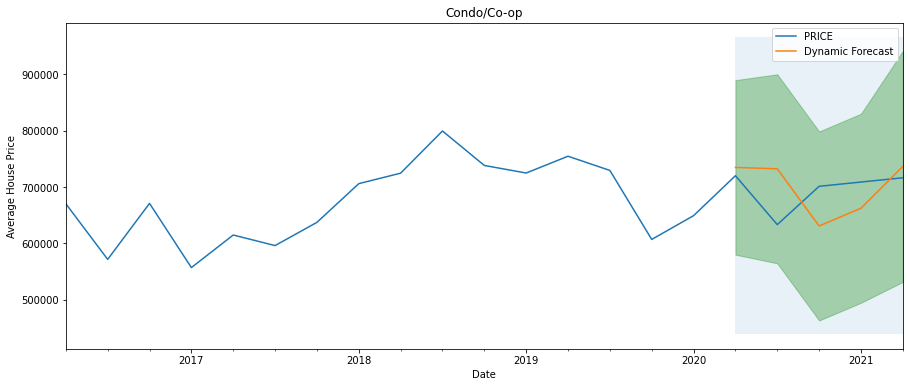

The Root Mean Squared Error of our forecasts for Condo/Co-op is 59159.97


Property_Type :  Single Family Residential
(0, 0, 1) (0, 1, 1, 4)
Model AIC:  295.24


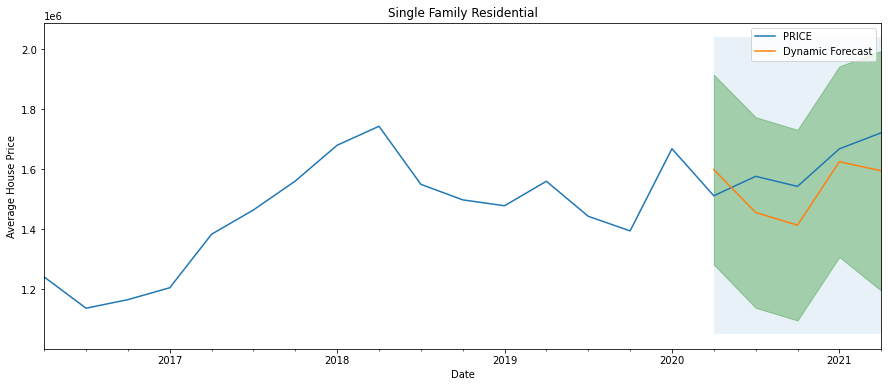

The Root Mean Squared Error of our forecasts for Single Family Residential is 106716.38


Property_Type :  Townhouse
(1, 0, 1) (0, 1, 1, 4)
Model AIC:  293.32


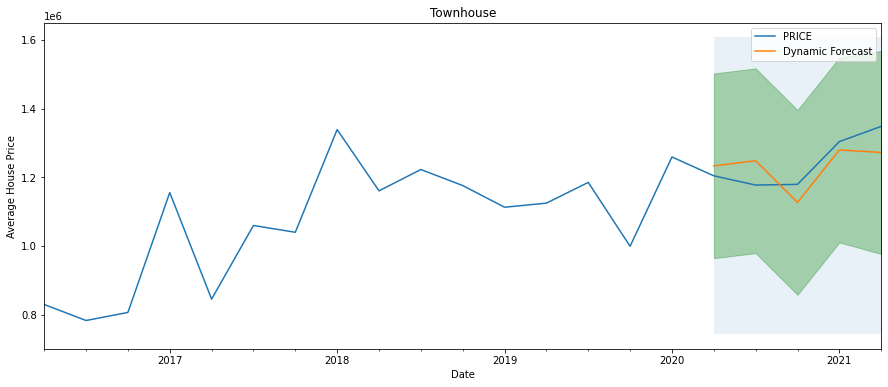

The Root Mean Squared Error of our forecasts for Townhouse is 54750.19


In [ ]:
summary_table_Type = Arima_Model(best_para_step2, 'Property_Type',proType_dfs)

#### Forecast

In [ ]:
forecast_table_Type = ModelForecast('Property_Type', summary_table_Type, proType_dfs, 4)
forecast_table_Type = round(forecast_table_Type,2)
forecast_table_Type

Property_Type  Current Value  ...  5Yr-CAGR-Lower  5Yr-CAGR-Upper
0                Condo/Co-op      716333.33  ...          -10.41            7.40
1  Single Family Residential     1721781.07  ...           -8.66            5.57
2                  Townhouse     1348000.00  ...           -5.89            5.03

[3 rows x 20 columns]

In [ ]:
forecast_table_Type.sort_values(by='5Yr-CAGR', ascending= False)[['Property_Type', '5Yr-CAGR']]
#change label

Property_Type  5Yr-CAGR
2                  Townhouse      0.16
0                Condo/Co-op      0.06
1  Single Family Residential     -0.53

### Step 2 (Holt-winter filter).Within the highest ROI Zip Code, find the highest ROI property type

In [ ]:
# 3 yr annual rate of return

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

step2_df = housing.loc[(housing['ZIP OR POSTAL CODE']== highest_zipcode)][['SOLD DATE', 'PROPERTY TYPE','PRICE']]
step2_df['SOLD DATE'] = step2_df['SOLD DATE'].apply(lambda x:x.strftime("%Y-%m-01"))
step2_df['SOLD DATE'] = pd.to_datetime(step2_df['SOLD DATE'])
step2_df2 = step2_df.groupby(['SOLD DATE','PROPERTY TYPE']).mean().sort_values(by = ['SOLD DATE', 'PROPERTY TYPE']).reset_index()
step2_df2.set_index('SOLD DATE', inplace = True)
step2_df2.head()

PROPERTY TYPE         PRICE
SOLD DATE                                          
2016-05-01                Condo/Co-op  5.525000e+05
2016-05-01  Single Family Residential  1.256429e+06
2016-05-01                  Townhouse  9.453333e+05
2016-06-01                Condo/Co-op  6.899382e+05
2016-06-01  Single Family Residential  1.232976e+06

In [ ]:
Ptype = ['Single Family Residential','Townhouse','Condo/Co-op'] # maybe add condo for other zipcode , 

ROI = []


for i in Ptype:
  df_HW2 = pd.DataFrame(step2_df2[step2_df2['PROPERTY TYPE']==i][['PRICE']].copy())

  #Fill NA with moving average
  rolling2 = df_HW2['PRICE'].rolling(3,center=True,min_periods=1).mean()
  rolling2_df = pd.DataFrame(rolling2)
  df_HW2.update(rolling2_df, overwrite = False)
  df_HW2.index = pd.DatetimeIndex(df_HW2.index.values, freq='MS')

  m = 12
  alpha = 1/(2*m)

  # only start with consecutive index
  step2_df3 = df_HW2[-15:]    #use data from 2018-04-01 to now for prdiction
  

  #split train/test
  train_step2_df3 = step2_df3[:14] 
  test_step2_df3 = step2_df3[14:]

  #fit model & plot
  fitted_model = ExponentialSmoothing(train_step2_df3['PRICE'],trend='mul',seasonal='mul',seasonal_periods=6).fit() #12
  test_predictions = fitted_model.forecast(37)    #predict untill 2023-10-01 

  # train_step2_df3['PRICE'].plot(legend=True,label='TRAIN')
  # test_step2_df3['PRICE'].plot(legend=True,label='TEST',figsize=(6,4))
  # test_predictions.plot(legend=True,label='PREDICTION')
  # plt.title('Train, Test and Predicted Test using Holt Winters')

  #ROI
  pred_p = pd.DataFrame(test_predictions)
  pred_p.columns = ['PRICE']
  ROI_rate = round(((pred_p['PRICE'].values[-1] / pred_p['PRICE'].values[0] ) **(1/3) - 1)*100,2)

  ROI.append(ROI_rate)

data = list(zip(Ptype, ROI))
df = pd.DataFrame(data, columns=['Property Type','3YR-CAGR']) #return from 2021-10 to 2023-10 (3yr)
df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Property Type  3YR-CAGR
0  Single Family Residential     16.54
1                  Townhouse      8.89
2                Condo/Co-op       NaN

## Modeling - TensorFlow - RNN

# Non-Time Series - Modeling

### EDA

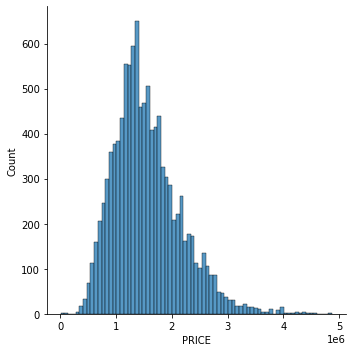

In [ ]:
#origial 
sns.displot(housing['PRICE'])

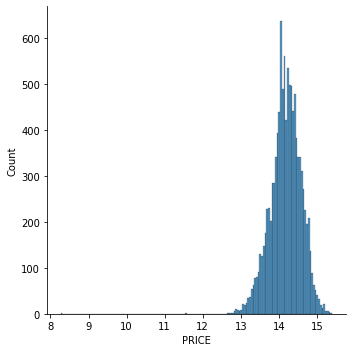

In [ ]:
#log transform
sns.displot(np.log(housing['PRICE']))

In [ ]:
sns.pairplot(housing)

Output hidden; open in https://colab.research.google.com to view.

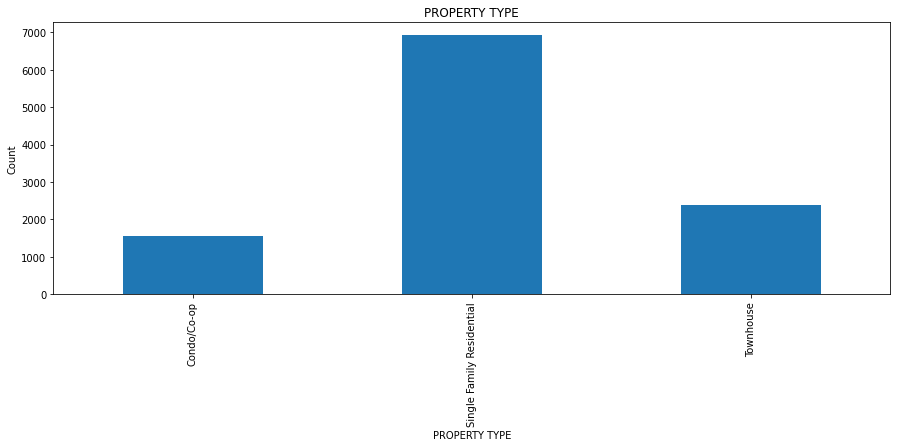

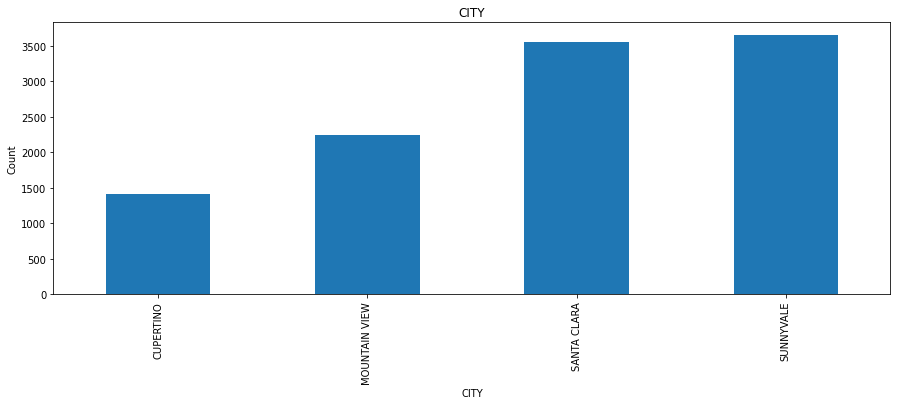

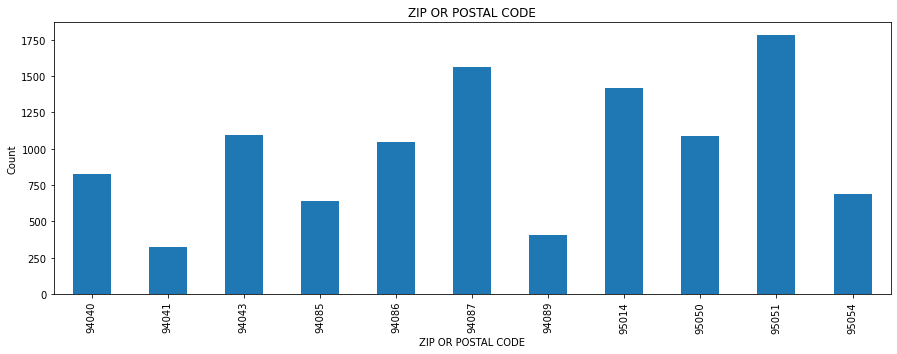

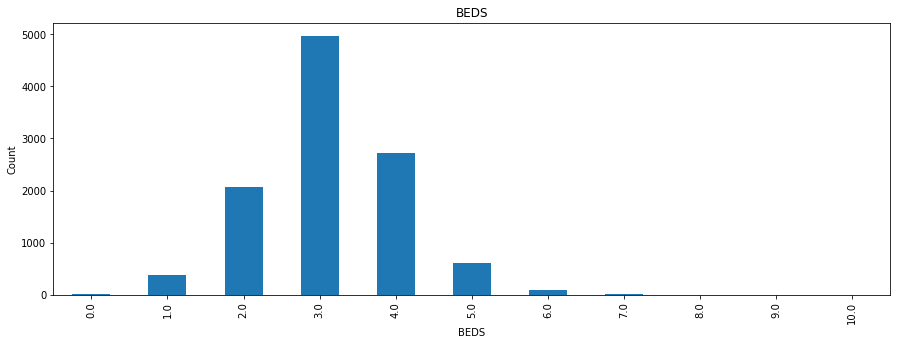

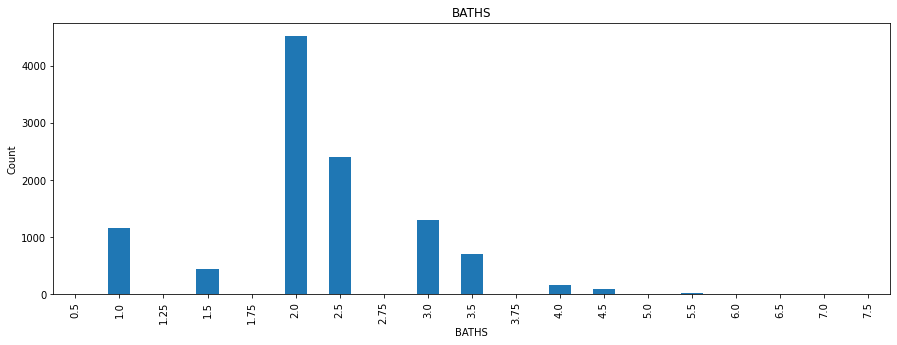

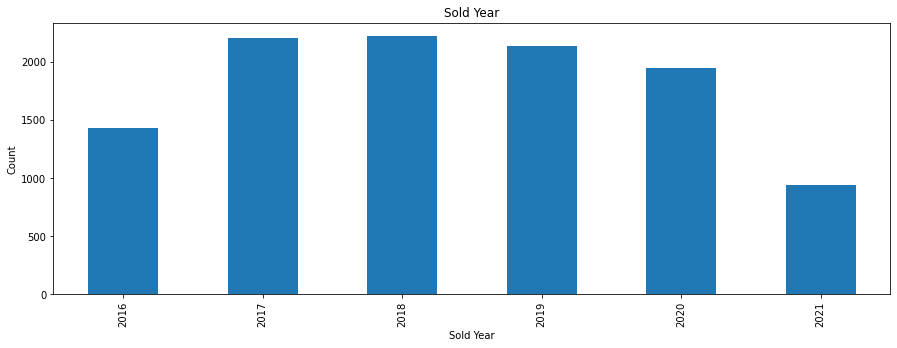

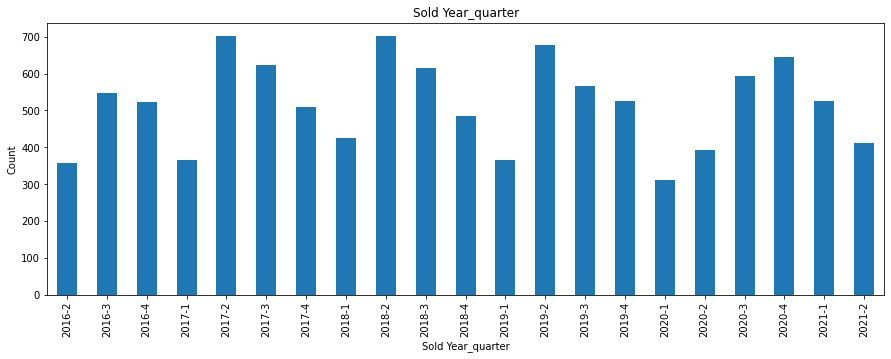

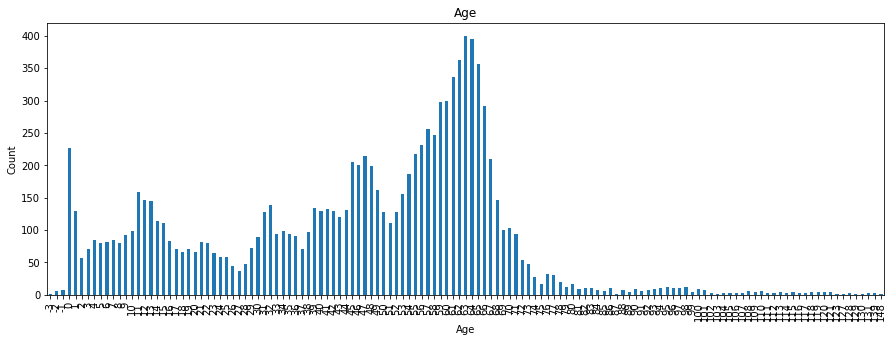

In [ ]:
#check general info 

categorized_x = ['PROPERTY TYPE', 'CITY', 'ZIP OR POSTAL CODE', 'BEDS', 'BATHS', 'Sold Year', 'Sold Year_quarter', 'Age']

for i in categorized_x:
  
  plt.figure(figsize = (15,5))
  housing[i].value_counts().sort_index().plot(kind='bar')
  plt.title(i)
  plt.xlabel(i)
  plt.ylabel('Count')
# sns.despine

In [ ]:
housing.head()

SOLD DATE              PROPERTY TYPE  ... Sold Year_quarter Age
0 2017-12-29                Condo/Co-op  ...            2017-4  42
1 2018-07-18  Single Family Residential  ...            2018-3  64
2 2018-11-21                Condo/Co-op  ...            2018-4  56
4 2021-03-11                  Townhouse  ...            2021-1  42
5 2017-03-16  Single Family Residential  ...            2017-1  64

[5 rows x 18 columns]

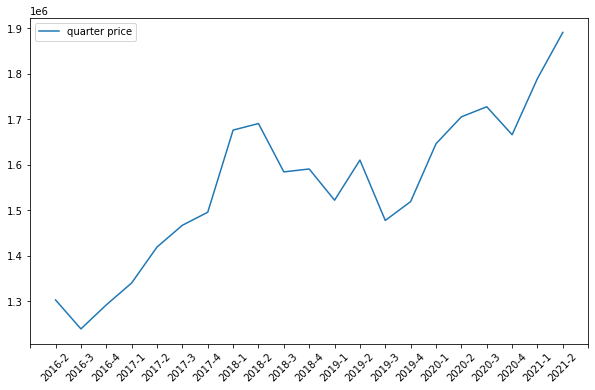

In [ ]:

ticker_spacing = 1

fig, ax = plt.subplots(1,figsize= (10,6))
plot_df = housing[['Sold Year','Sold Year_quarter','PRICE']]
plot_df = plot_df.groupby('Sold Year_quarter').mean().reset_index()
ax.plot(plot_df['Sold Year_quarter'], plot_df['PRICE'], label = 'quarter price')


ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.xticks(rotation = 45)
plt.legend()
plt.show()

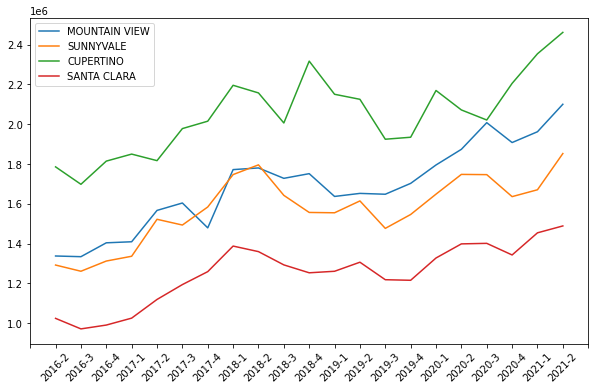

In [ ]:
#Time Series Plot
# ticker_spacing = plot_df['Sold Year_quarter']
ticker_spacing = 1

fig, ax = plt.subplots(1,figsize= (10,6))

for i in housing['CITY'].unique():

  plot_df = housing.loc[housing['CITY']==i][['Sold Year','Sold Year_quarter','PRICE']]
  plot_df = plot_df.groupby('Sold Year_quarter').mean().reset_index()
  ax.plot(plot_df['Sold Year_quarter'], plot_df['PRICE'], label = i)


ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.xticks(rotation = 45)
plt.legend()
plt.show()

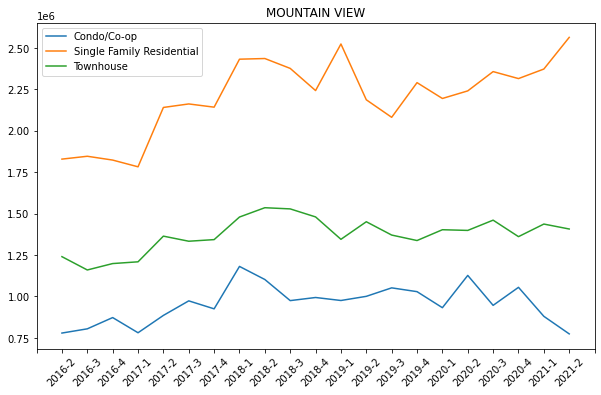

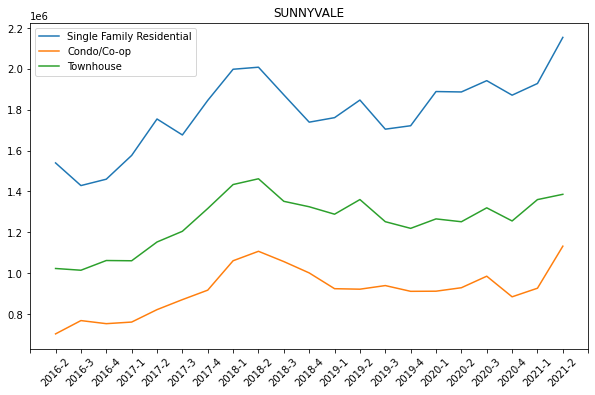

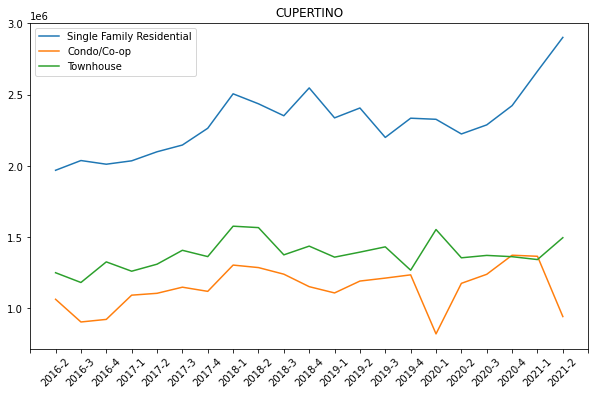

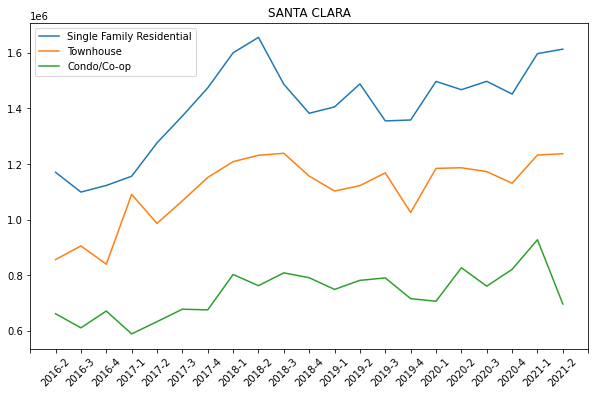

In [ ]:
#Time Series Plot
for i in housing['CITY'].unique():
  fig, ax = plt.subplots(1,figsize= (10,6))
  for j in housing[housing['CITY']==i]['PROPERTY TYPE'].unique():
    
    plot_df = housing.loc[(housing['CITY']==i) & (housing['PROPERTY TYPE']==j)][['Sold Year_quarter','PRICE']]
    plot_df = plot_df.groupby('Sold Year_quarter').mean().reset_index()

    
    ax.plot(plot_df['Sold Year_quarter'], plot_df['PRICE'], label = j)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
    plt.xticks(rotation = 45)
    plt.title(i)
  plt.legend()
  plt.show()

In [ ]:
# check correlation
corrMatrix = housing.corr()
corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(2)

According to corr plot, the variables that might be associated the most with housing price are: BATHS, SQFT, and BEDS. 

In [ ]:
housing.head()

SOLD DATE              PROPERTY TYPE  ... Sold Year_quarter Age
0 2017-12-29                Condo/Co-op  ...            2017-4  42
1 2018-07-18  Single Family Residential  ...            2018-3  64
2 2018-11-21                Condo/Co-op  ...            2018-4  56
4 2021-03-11                  Townhouse  ...            2021-1  42
5 2017-03-16  Single Family Residential  ...            2017-1  64

[5 rows x 18 columns]

In [ ]:
# housing['Sold Year'] = housing['Sold Year'].astype('category')

In [ ]:
housing_cut = housing.drop(['SOLD DATE', 'CITY','STATE OR PROVINCE','YEAR BUILT','LATITUDE','LONGITUDE'], axis = 1)
housing_cut.head()

PROPERTY TYPE ZIP OR POSTAL CODE  ...  Sold Year_quarter  Age
0                Condo/Co-op              94040  ...             2017-4   42
1  Single Family Residential              94040  ...             2018-3   64
2                Condo/Co-op              94040  ...             2018-4   56
4                  Townhouse              94040  ...             2021-1   42
5  Single Family Residential              94040  ...             2017-1   64

[5 rows x 12 columns]

In [ ]:
df = housing_cut.drop(['Sold Year_quarter'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10864 entries, 0 to 12764
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PROPERTY TYPE       10864 non-null  category
 1   ZIP OR POSTAL CODE  10864 non-null  category
 2   PRICE               10864 non-null  int64   
 3   BEDS                10864 non-null  float64 
 4   BATHS               10864 non-null  float64 
 5   SQUARE FEET         10864 non-null  float64 
 6   LOT SIZE            10864 non-null  float64 
 7   DAYS ON MARKET      10864 non-null  int64   
 8   Sold Year           10864 non-null  int64   
 9   Sold Quarter        10864 non-null  int64   
 10  Age                 10864 non-null  int64   
dtypes: category(2), float64(4), int64(5)
memory usage: 870.5 KB


### Dummy convertion

In [ ]:
# dummy - Zip code

categorized_x = ['PROPERTY TYPE', 'ZIP OR POSTAL CODE', 'Sold Year', 'Sold Quarter']
for i in categorized_x:
  dummy = pd.get_dummies(df[i], drop_first= True)
  df = pd.concat([df,dummy], axis = 1)
  df = df.drop([i], axis= 1)
df

PRICE  BEDS  BATHS  SQUARE FEET  LOT SIZE  ...  2020  2021  2  3  4
0       725000   1.0    1.0        763.0    1300.0  ...     0     0  0  0  1
1      2650000   3.0    3.0       1728.0    5160.0  ...     0     0  0  1  0
2       710000   1.0    1.0        756.0     756.0  ...     0     0  0  0  1
4      1500000   2.0    2.5       1648.0    1351.0  ...     0     1  0  0  0
5      1850000   3.0    2.0       1178.0    5980.0  ...     0     0  0  0  0
...        ...   ...    ...          ...       ...  ...   ...   ... .. .. ..
12760   880000   3.0    2.5       1564.0    1491.0  ...     0     0  0  0  0
12761   850000   2.0    2.0       1148.0    1158.0  ...     0     1  0  0  0
12762  1270000   4.0    3.0       2050.0    6480.0  ...     1     0  0  1  0
12763  1475000   4.0    2.0       1314.0    6523.0  ...     0     1  1  0  0
12764  1485000   3.0    2.5       1907.0    1302.0  ...     0     1  1  0  0

[10864 rows x 27 columns]

In [ ]:
df.head()

PRICE  BEDS  BATHS  SQUARE FEET  LOT SIZE  ...  2020  2021  2  3  4
0   725000   1.0    1.0        763.0    1300.0  ...     0     0  0  0  1
1  2650000   3.0    3.0       1728.0    5160.0  ...     0     0  0  1  0
2   710000   1.0    1.0        756.0     756.0  ...     0     0  0  0  1
4  1500000   2.0    2.5       1648.0    1351.0  ...     0     1  0  0  0
5  1850000   3.0    2.0       1178.0    5980.0  ...     0     0  0  0  0

[5 rows x 27 columns]

### Train/Test split

In [ ]:
y = df['PRICE']
x = df.drop(['PRICE'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,random_state = 423)

### Scale

In [ ]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler

#do scaling
x_train_scale = x_train.copy()
x_test_scale = x_test.copy()
y_train_scale = y_train.copy()
y_test_scale = y_test.copy()


#store Mean, std from train, and standardize to test data

# numerical features
num_cols = ['BEDS','BATHS', 'SQUARE FEET','LOT SIZE','DAYS ON MARKET','Age']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = MinMaxScaler().fit(x_train_scale[[i]])
    
    # transform the training data column
    x_train_scale[i] = scale.transform(x_train_scale[[i]])
    
    # transform the testing data column
    x_test_scale[i] = scale.transform(x_test_scale[[i]])

### 1.LinearRegression

In [ ]:


#define the function to plot prediction vs true

def TruePredictPlot(model, x_test, y_test):

  y_pred= model.predict(x_test)

  plt.figure(figsize=[8,6])
  plt.scatter(y_test, y_pred)
  plt.plot([0,max(y_test)],[0, max(y_test)], c = 'red')
  plt.title('Actual vs Prediction')
  plt.xlabel('Actual')
  plt.ylabel('Prediction')
  plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

R_squared_OOS = {}
MAE_OOS = {}
MAPE_OOS = {}

def linear_eval(model, name, x_test=x_test, y_test=y_test):
  R_squared_OOS[name] = r2_score(y_test, model.predict(x_test))
  print("(Out of sample) R squared is: ",R_squared_OOS[name])

  MAE_OOS[name] = mean_absolute_error(y_test, model.predict(x_test))
  print("(Out of sample) mean absolute error is: ",MAE_OOS[name])

  MAPE_OOS[name] = mean_absolute_percentage_error(y_test, model.predict(x_test))
  print("(Out of sample) mean absolute percentage error is: ",MAPE_OOS[name])



In [ ]:
#non-Scale
lm_reg = LinearRegression().fit(x_train,y_train)
linear_eval(lm_reg, 'Linear_Nonscale')

(Out of sample) R squared is:  0.8300922883259337
(Out of sample) mean absolute error is:  185357.99354921543
(Out of sample) mean absolute percentage error is:  0.12870025006394545


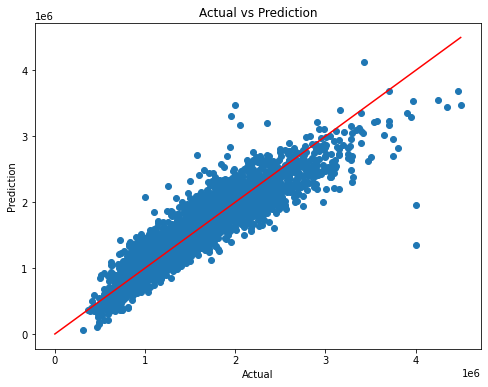

In [ ]:
TruePredictPlot(lm_reg, x_test, y_test)

In [ ]:
# Load modules and data
import numpy as np
import statsmodels.api as sm

x_train_sm = sm.add_constant(x_train)

# Fit and summarize OLS model
model_sm = sm.OLS(y_train, x_train_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1561.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:34:36   Log-Likelihood:            -1.0496e+05
No. Observations:                7604   AIC:                         2.100e+05
Df Residuals:                    7577   BIC:                         2.102e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
linear_eval(model_sm, 'Linear_sm', sm.add_constant(x_test),y_test)

(Out of sample) R squared is:  0.8300922883259385
(Out of sample) mean absolute error is:  185357.99354921447
(Out of sample) mean absolute percentage error is:  0.12870025006393904


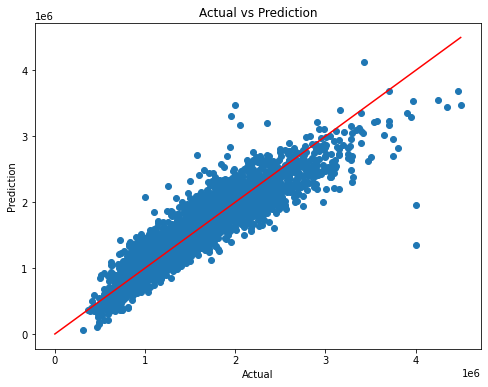

In [ ]:
TruePredictPlot(model_sm, sm.add_constant(x_test), y_test)

In [ ]:
#Scale
lm_reg2 = LinearRegression().fit(x_train_scale,y_train)
linear_eval(lm_reg2, 'Linear_scale', x_test_scale)

(Out of sample) R squared is:  0.8300922883259341
(Out of sample) mean absolute error is:  185357.99354921543
(Out of sample) mean absolute percentage error is:  0.12870025006394503


In [ ]:
x_train_scale_sm = sm.add_constant(x_train_scale)

# Fit and summarize OLS model
model_sm2 = sm.OLS(y_train, x_train_scale_sm).fit()
print(model_sm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1561.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:34:37   Log-Likelihood:            -1.0496e+05
No. Observations:                7604   AIC:                         2.100e+05
Df Residuals:                    7577   BIC:                         2.102e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### 1.1 Lasso

In [ ]:
from sklearn import linear_model

#non-scale
lasso_reg = linear_model.Lasso(alpha=0.1, max_iter=10000,tol = 0.01, random_state = 33, normalize = True).fit(x_train,y_train)
# print("(in sample) R squared is: ", lasso_reg.score(x_train,y_train))
# print("(Out of sample) R squared is: ", lasso_reg.score(x_test,y_test))
linear_eval(lasso_reg, 'Linear_Lasso_nonscale')

(Out of sample) R squared is:  0.8300788155526317
(Out of sample) mean absolute error is:  185373.7451047169
(Out of sample) mean absolute percentage error is:  0.12869803718855208


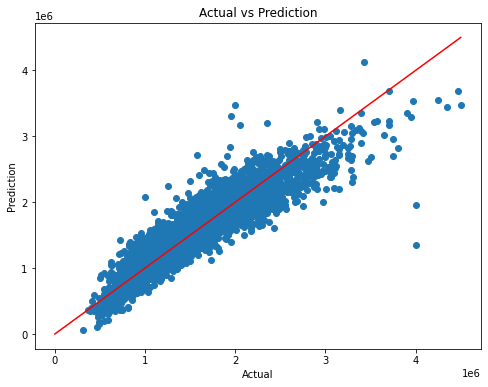

In [ ]:
TruePredictPlot(lasso_reg, x_test, y_test)

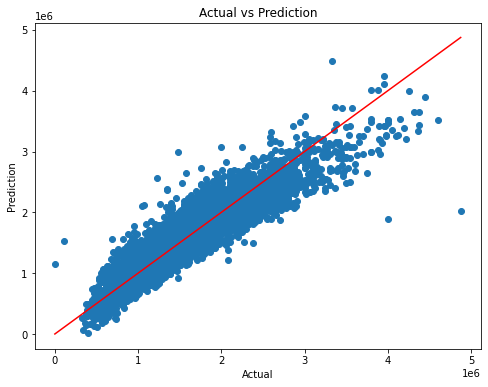

In [ ]:
TruePredictPlot(lasso_reg, x_train,y_train)

In [ ]:
#Scale
lasso_reg2 = linear_model.Lasso(alpha=0.1, max_iter=10000,tol = 0.01, random_state = 33, normalize = True).fit(x_train_scale,y_train)
linear_eval(lasso_reg2, 'Linear_Lasso_scale',x_test_scale)

(Out of sample) R squared is:  0.8300788155526317
(Out of sample) mean absolute error is:  185373.7451047169
(Out of sample) mean absolute percentage error is:  0.1286980371885521


#### 1.2 Lasso CV

In [ ]:
from sklearn.linear_model import LassoCV
#non-scale
lasso_regCV = LassoCV(cv=5, random_state=44,normalize = True).fit(x_train,y_train)
# print("(Out of sample) R squared is: ", lasso_regCV.score(x_test,y_test))
linear_eval(lasso_regCV, 'Linear_LassoCV_nonscale')

(Out of sample) R squared is:  0.8299243349308586
(Out of sample) mean absolute error is:  185222.610653575
(Out of sample) mean absolute percentage error is:  0.1281800992846805


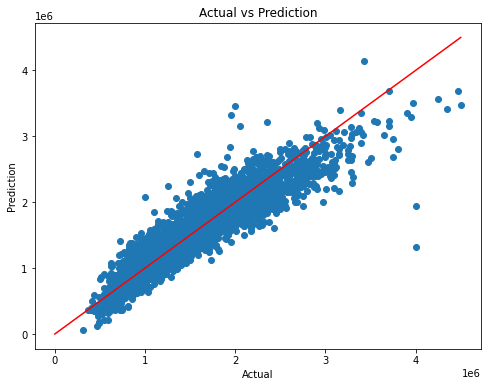

In [ ]:
TruePredictPlot(lasso_regCV, x_test, y_test)

In [ ]:
#Scale
lasso_regCV2 = LassoCV(cv=5, random_state=44,normalize = True).fit(x_train_scale,y_train)
# print("(Out of sample) R squared is: ", lasso_regCV2.score(x_test_scale,y_test))
linear_eval(lasso_regCV2, 'Linear_LassoCV_scale', x_test_scale)

(Out of sample) R squared is:  0.8299243349308586
(Out of sample) mean absolute error is:  185222.61065357507
(Out of sample) mean absolute percentage error is:  0.1281800992846805


### 2.Random Forest

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf_reg = RandomForestRegressor(n_estimators = 2000, random_state = 42).fit(x_train, y_train)

# # Use the forest's predict method on the test data
# rf_pred = rf_reg.predict(x_test)

# # Calculate the absolute errors (AE)
# errors = abs(rf_pred - y_test)
# # Print out the mean absolute error (mae)
# print('(out of sample) Mean Absolute Error (MAE):', round(np.mean(errors), 2), 'Dollars.')

# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / y_test)
# # Calculate and display accuracy

# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')
linear_eval(rf_reg, 'RF_nonscale')

(Out of sample) R squared is:  0.8760546222602631
(Out of sample) mean absolute error is:  141670.9511537175
(Out of sample) mean absolute percentage error is:  0.09111607303272129


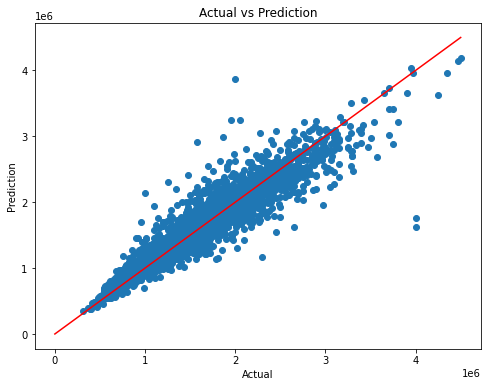

In [ ]:
TruePredictPlot(rf_reg, x_test, y_test)

In [ ]:
rf_reg2 = RandomForestRegressor(n_estimators = 2000, random_state = 42).fit(x_train_scale, y_train)
linear_eval(rf_reg2, 'RF_scale', x_test_scale)

(Out of sample) R squared is:  0.875996386424689
(Out of sample) mean absolute error is:  141682.92637762197
(Out of sample) mean absolute percentage error is:  0.09112563173245773


### 3.Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
boost_reg = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 4,
          learning_rate = 0.1, loss = 'ls')
boost_reg.fit(x_train, y_train)
linear_eval(boost_reg, 'GB_Nonscale')

(Out of sample) R squared is:  0.893732282573087
(Out of sample) mean absolute error is:  132262.6494446396
(Out of sample) mean absolute percentage error is:  0.08458076431280416


### Evaluation

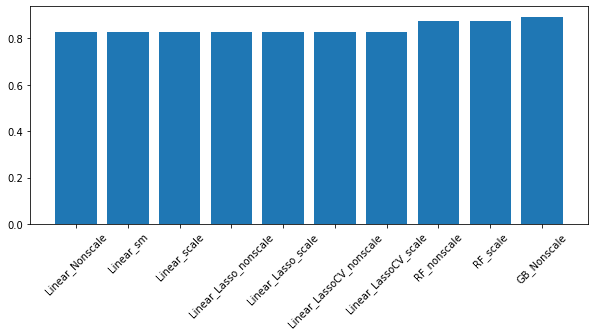

{'GB_Nonscale': 0.893732282573087,
 'Linear_LassoCV_nonscale': 0.8299243349308586,
 'Linear_LassoCV_scale': 0.8299243349308586,
 'Linear_Lasso_nonscale': 0.8300788155526317,
 'Linear_Lasso_scale': 0.8300788155526317,
 'Linear_Nonscale': 0.8300922883259337,
 'Linear_scale': 0.8300922883259341,
 'Linear_sm': 0.8300922883259385,
 'RF_nonscale': 0.8760546222602631,
 'RF_scale': 0.875996386424689}

In [ ]:
#Plot R2
plt.bar(*zip(*R_squared_OOS.items()))
plt.xticks(rotation = 45)
plt.show()
R_squared_OOS

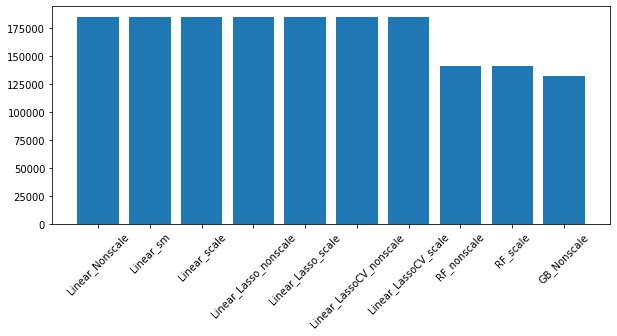

{'GB_Nonscale': 132262.6494446396,
 'Linear_LassoCV_nonscale': 185222.610653575,
 'Linear_LassoCV_scale': 185222.61065357507,
 'Linear_Lasso_nonscale': 185373.7451047169,
 'Linear_Lasso_scale': 185373.7451047169,
 'Linear_Nonscale': 185357.99354921543,
 'Linear_scale': 185357.99354921543,
 'Linear_sm': 185357.99354921447,
 'RF_nonscale': 141670.9511537175,
 'RF_scale': 141682.92637762197}

In [ ]:
#Plot MSE
plt.bar(*zip(*MAE_OOS.items()))
plt.xticks(rotation = 45)
plt.show()
MAE_OOS

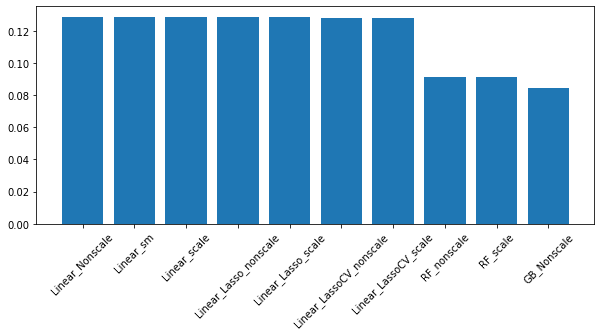

{'GB_Nonscale': 0.08458076431280416,
 'Linear_LassoCV_nonscale': 0.1281800992846805,
 'Linear_LassoCV_scale': 0.1281800992846805,
 'Linear_Lasso_nonscale': 0.12869803718855208,
 'Linear_Lasso_scale': 0.1286980371885521,
 'Linear_Nonscale': 0.12870025006394545,
 'Linear_scale': 0.12870025006394503,
 'Linear_sm': 0.12870025006393904,
 'RF_nonscale': 0.09111607303272129,
 'RF_scale': 0.09112563173245773}

In [ ]:
#Plot MAPE
plt.bar(*zip(*MAPE_OOS.items()))
plt.xticks(rotation = 45)
plt.show()
MAPE_OOS

# Other tries

## TensorFlow - RNN

### Data preparation

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
rnn_df = housing[['SOLD DATE','PRICE','ZIP OR POSTAL CODE','PROPERTY TYPE']]
rnn_df

SOLD DATE    PRICE ZIP OR POSTAL CODE              PROPERTY TYPE
0     2017-12-29   725000              94040                Condo/Co-op
1     2018-07-18  2650000              94040  Single Family Residential
2     2018-11-21   710000              94040                Condo/Co-op
4     2021-03-11  1500000              94040                  Townhouse
5     2017-03-16  1850000              94040  Single Family Residential
...          ...      ...                ...                        ...
12760 2017-01-04   880000              95054                  Townhouse
12761 2021-02-24   850000              95054                Condo/Co-op
12762 2020-07-01  1270000              95054  Single Family Residential
12763 2021-05-06  1475000              95054  Single Family Residential
12764 2021-04-29  1485000              95054                  Townhouse

[10864 rows x 4 columns]

In [ ]:
rnn_df['SOLD DATE'] = rnn_df['SOLD DATE'].apply(lambda x:x.strftime("%Y-%m-01"))
rnn_df['SOLD DATE'] = pd.to_datetime(rnn_df['SOLD DATE'])
rnn_df2 = rnn_df.groupby(['SOLD DATE','ZIP OR POSTAL CODE', 'PROPERTY TYPE']).mean().sort_values(by = ['SOLD DATE','ZIP OR POSTAL CODE', 'PROPERTY TYPE']).reset_index()
rnn_df2.head()

SOLD DATE ZIP OR POSTAL CODE              PROPERTY TYPE         PRICE
0 2016-05-01              94040                Condo/Co-op  7.396667e+05
1 2016-05-01              94040  Single Family Residential  1.900944e+06
2 2016-05-01              94040                  Townhouse  1.383750e+06
3 2016-05-01              94041                Condo/Co-op  8.000000e+05
4 2016-05-01              94041  Single Family Residential  1.891714e+06

In [ ]:
# rnn_pivot_df = rnn_df2.copy()
# categorized_x2 = ['PROPERTY TYPE', 'ZIP OR POSTAL CODE']
# for i in categorized_x2:
#   dummy = pd.get_dummies(rnn_pivot_df[i])
#   rnn_pivot_df = pd.concat([rnn_pivot_df,dummy], axis = 1)
#   rnn_pivot_df = rnn_pivot_df.drop([i], axis= 1)
# rnn_pivot_df

In [ ]:
# rnn_pivot_df = rnn_df2.pivot(index='SOLD DATE', columns='ZIP OR POSTAL CODE', values='PRICE')
# rnn_pivot_df.columns = rnn_pivot_df.columns.astype(str)
# rnn_pivot_df = rnn_pivot_df.reset_index(level ='SOLD DATE')
# rnn_pivot_df.head()

In [ ]:
rnn_pivot_df = rnn_df2.loc[(rnn_df2['ZIP OR POSTAL CODE']==95051) & (rnn_df2['PROPERTY TYPE']=='Townhouse')].reset_index(drop = True)
rnn_pivot_df= rnn_pivot_df[['SOLD DATE','PRICE']]
rnn_pivot_df.head()

SOLD DATE          PRICE
0 2016-05-01  945333.333333
1 2016-06-01  655000.000000
2 2016-07-01  708335.000000
3 2016-08-01  832000.000000
4 2016-09-01            NaN

### Fill in NA with moving average

In [ ]:
#Original Dataset - Missing value (no sales happened in the month)
rnn_pivot_df[rnn_pivot_df.isna().any(axis=1)]

SOLD DATE  PRICE
4  2016-09-01    NaN
13 2017-06-01    NaN
45 2020-02-01    NaN

In [ ]:
np.sum(rnn_pivot_df.isna())

SOLD DATE    0
PRICE        3
dtype: int64

In [ ]:
#fill in the NA with the price 1 month before and after (i.e. Moving average)

for col in rnn_pivot_df.columns:
  na_index = rnn_pivot_df[col].index[rnn_pivot_df[col].isna()]
  if len(na_index)>0:
    for idx in na_index:
      if (idx+1) not in na_index:
        rnn_pivot_df[col].iloc[idx] = np.mean(rnn_pivot_df[col].iloc[idx-1]+rnn_pivot_df[col].iloc[idx+1])/2
      else:
        if (idx+2) not in na_index:
          rnn_pivot_df[col].iloc[idx] = np.mean(rnn_pivot_df[col].iloc[idx-1])+(rnn_pivot_df[col].iloc[idx+2]-np.mean(rnn_pivot_df[col].iloc[idx-1]))/3
        else:
          rnn_pivot_df[col].iloc[idx] = np.mean(rnn_pivot_df[col].iloc[idx-1])+(rnn_pivot_df[col].iloc[idx+3]-np.mean(rnn_pivot_df[col].iloc[idx-1]))/4




In [ ]:
np.sum(rnn_pivot_df.isna())

SOLD DATE    0
PRICE        0
dtype: int64

In [ ]:
date_time = pd.to_datetime(rnn_pivot_df.pop('SOLD DATE'), format='%d.%m.%Y')
date_time[:5]

0   2016-05-01
1   2016-06-01
2   2016-07-01
3   2016-08-01
4   2016-09-01
Name: SOLD DATE, dtype: datetime64[ns]

In [ ]:
rnn_pivot_df.describe()

PRICE
count  6.100000e+01
mean   1.116786e+06
std    1.952091e+05
min    6.550000e+05
25%    9.700000e+05
50%    1.133375e+06
75%    1.263750e+06
max    1.450000e+06

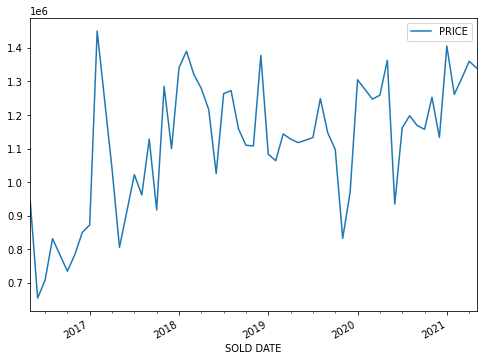

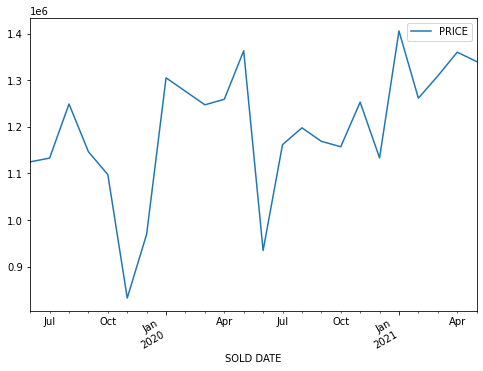

In [ ]:
plot_cols = rnn_pivot_df.columns
plot_features = rnn_pivot_df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = rnn_pivot_df[plot_cols][-24:]
plot_features.index = date_time[-24:]
_ = plot_features.plot(subplots=True)

### Split the data

We'll use a `(70%, 30%)` split for the training and test sets. Note the data is **not** being randomly shuffled before splitting. It is splited based on the timeline.

In [ ]:
column_indices = {name: i for i, name in enumerate(rnn_pivot_df.columns)}

n = len(rnn_pivot_df)
train_df = rnn_pivot_df[0:int(n*0.7)]
# val_df = rnn_pivot_df[int(n*0.7):int(n*0.9)]
test_df = rnn_pivot_df[int(n*0.7):]

num_features = rnn_pivot_df.shape[1]

In [ ]:
train_df.head()

PRICE
0  945333.333333
1  655000.000000
2  708335.000000
3  832000.000000
4  783500.000000

In [ ]:
test_df.head()

PRICE
42   832972.0
43   970000.0
44  1305000.0
45  1276125.0
46  1247250.0

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature. 

We use **StandardScaler** here (i.e. (x-mean)/std). Alternatively, we could also use MinMaxScaler (i.e. X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)), X_scaled = X_std * (max - min) + min)

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

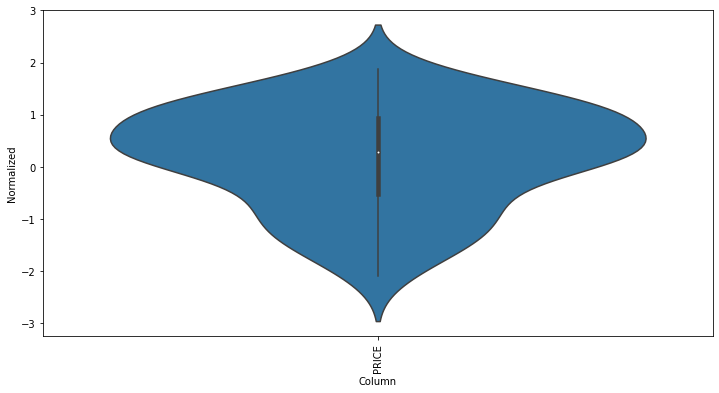

In [ ]:
df_std = (rnn_pivot_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(rnn_pivot_df.keys(), rotation=90)

### WindowGenerator

The window function is similar to the lag and seasonality that links the historical data to predict the coming.

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 


Following is an example of a model that makes a prediction 1 period into the future, given 6 periods of history would need a window like this:

  ![One prediction 1h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df,test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}


    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def plot(self, model=None, max_subplots=3):
    for label_col in self.label_columns:
      plot_col = label_col
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

      plt.xlabel('Month [m]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=24)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
  return self.make_dataset(self.train_df)
@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.example = example
  

### compile_and_fit

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.test,
                      callbacks=[early_stopping])
  return history

### Modeling 


#### Single step models

use Time t info to predict Time t+1


###### Single Step

use one past period to predict one future period (T(0) to predict T(1))

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['PRICE'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['PRICE']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (24, 1, 1)
Labels shape (batch, time, features): (24, 1, 1)


###### Wide Window
use multiple past period to predict multiple future period but the relationship is still one to one (T(0) to predict T(1), T(1) to predict T(2), T(2) to predict T(3) ...)

In [ ]:
wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=['PRICE'])

wide_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['PRICE']

In [ ]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (24, 12, 1)
Labels shape (batch, time, features): (24, 12, 1)


In [ ]:
performance = {}

##### Baseline 

(Only Use forecast T(1) by using T(0) value without running any models)

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['PRICE'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


performance['Single_Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

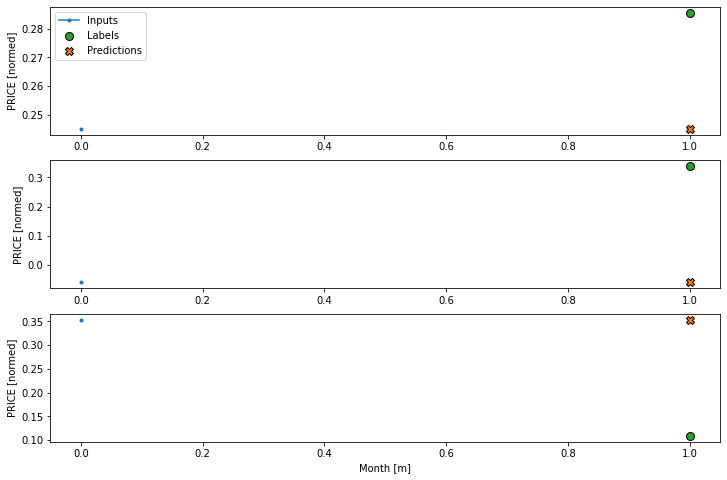

In [ ]:
single_step_window.plot(baseline)

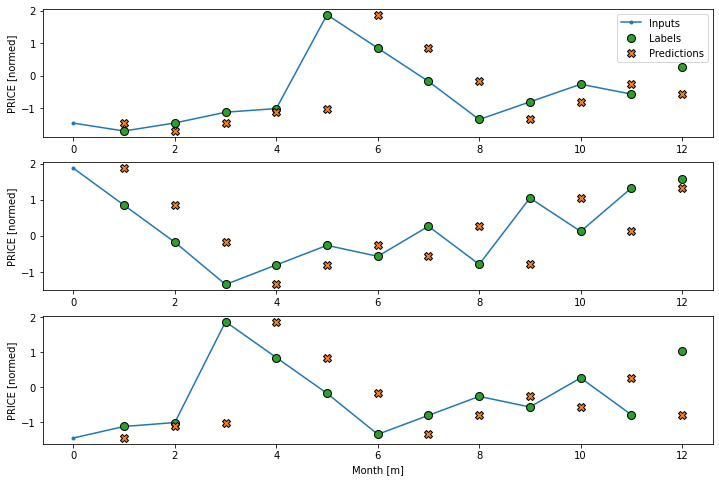

In [ ]:
wide_window.plot(baseline) # = shift to the right 1 step, since use T(n) to predict T(n+1)

##### Linear Model

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, months, inputs)` to `(batch, months, units)`, it is applied independently to every item across the `batch` and `months` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (24, 1, 1)
Output shape: (24, 1, 1)


In [ ]:
history = compile_and_fit(linear, single_step_window)

performance['Single_Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
2/2 [==============================] - 1s 161ms/step - loss: 5.4760 - mean_absolute_error: 1.8960 - val_loss: 5.2195 - val_mean_absolute_error: 2.0905
Epoch 2/20
2/2 [==============================] - 0s 59ms/step - loss: 5.4673 - mean_absolute_error: 1.8944 - val_loss: 5.2121 - val_mean_absolute_error: 2.0891
Epoch 3/20
2/2 [==============================] - 0s 65ms/step - loss: 5.4592 - mean_absolute_error: 1.8931 - val_loss: 5.2052 - val_mean_absolute_error: 2.0877
Epoch 4/20
2/2 [==============================] - 0s 57ms/step - loss: 5.4499 - mean_absolute_error: 1.8916 - val_loss: 5.1978 - val_mean_absolute_error: 2.0862
Epoch 5/20
2/2 [==============================] - 0s 69ms/step - loss: 5.4415 - mean_absolute_error: 1.8902 - val_loss: 5.1896 - val_mean_absolute_error: 2.0846
Epoch 6/20
2/2 [==============================] - 0s 55ms/step - loss: 5.4331 - mean_absolute_error: 1.8888 - val_loss: 5.1814 - val_mean_absolute_error: 2.0830
Epoch 7/20
2/2 [=================

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (24, 12, 1)
Output shape: (24, 12, 1)


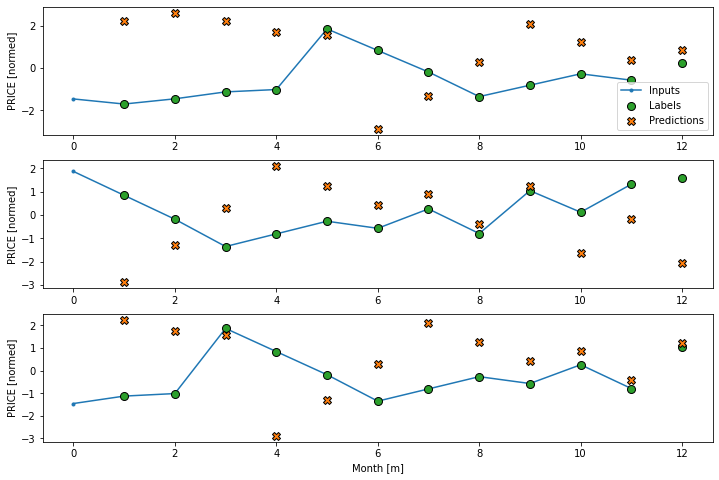

In [ ]:
wide_window.plot(linear)

##### Dense

Use multiple historial periods to forecast 1 future period

In [ ]:
# use 3 pasting periods to forecast 1 future period
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['PRICE'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['PRICE']

Given 3M as input, predict 1M into the future.


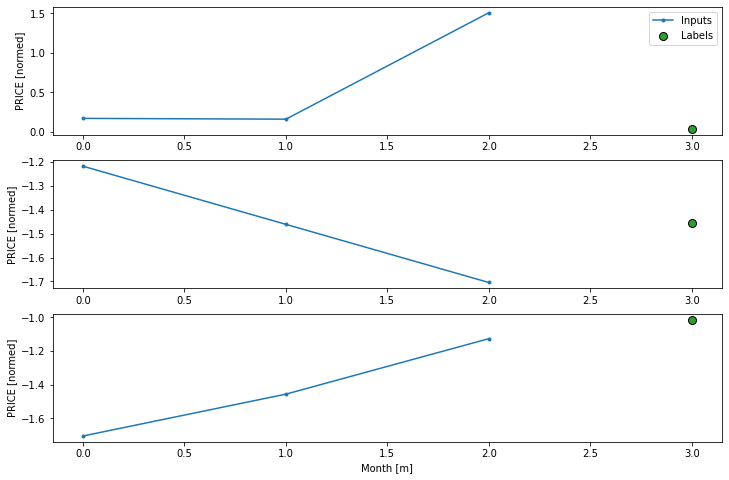

In [ ]:
print("Given 3M as input, predict 1M into the future.")
conv_window.plot()


In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['PRICE'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['PRICE']

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (24, 3, 1)
Output shape: (24, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

# IPython.display.clear_output()
print('\n')
print('Average Output')
# val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi input dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
2/2 [==============================] - 1s 178ms/step - loss: 0.4920 - mean_absolute_error: 0.5141 - val_loss: 0.4595 - val_mean_absolute_error: 0.5497
Epoch 2/20
2/2 [==============================] - 0s 60ms/step - loss: 0.4836 - mean_absolute_error: 0.5126 - val_loss: 0.4578 - val_mean_absolute_error: 0.5485
Epoch 3/20
2/2 [==============================] - 0s 55ms/step - loss: 0.4792 - mean_absolute_error: 0.5077 - val_loss: 0.4585 - val_mean_absolute_error: 0.5493
Epoch 4/20
2/2 [==============================] - 0s 52ms/step - loss: 0.4756 - mean_absolute_error: 0.5039 - val_loss: 0.4564 - val_mean_absolute_error: 0.5461
Epoch 5/20
2/2 [==============================] - 0s 63ms/step - loss: 0.4738 - mean_absolute_error: 0.5011 - val_loss: 0.4543 - val_mean_absolute_error: 0.5433
Epoch 6/20
2/2 [==============================] - 0s 57ms/step - loss: 0.4712 - mean_absolute_error: 0.4966 - val_loss: 0.4571 - val_mean_absolute_error: 0.5466
Epoch 7/20
2/2 [=================

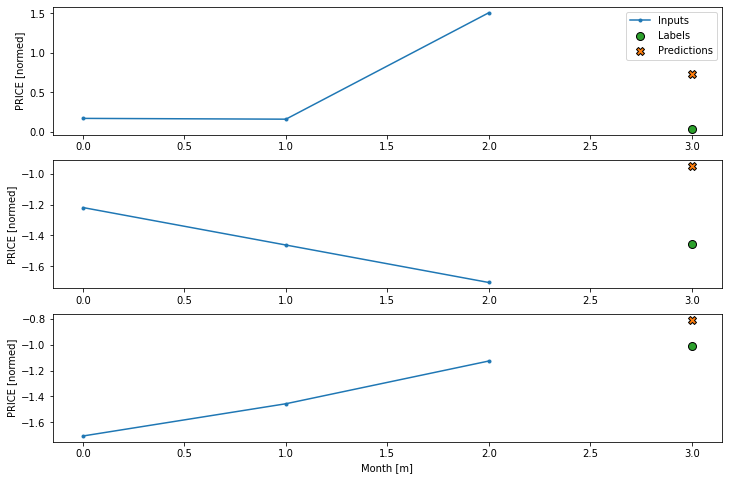

In [ ]:
conv_window.plot(multi_step_dense)

##### RNN

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_model(conv_window.example[0]).shape)

Input shape: (24, 3, 1)
Output shape: (24, 3, 1)


In [ ]:
history = compile_and_fit(lstm_model, conv_window)

# IPython.display.clear_output()
# val_performance['LSTM'] = lstm_model.evaluate(conv_window.val)
performance['LSTM'] = lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
2/2 [==============================] - 3s 488ms/step - loss: 0.8210 - mean_absolute_error: 0.7366 - val_loss: 0.9438 - val_mean_absolute_error: 0.8887
Epoch 2/20
2/2 [==============================] - 0s 66ms/step - loss: 0.8114 - mean_absolute_error: 0.7309 - val_loss: 0.9293 - val_mean_absolute_error: 0.8812
Epoch 3/20
2/2 [==============================] - 0s 60ms/step - loss: 0.8029 - mean_absolute_error: 0.7257 - val_loss: 0.9130 - val_mean_absolute_error: 0.8726
Epoch 4/20
2/2 [==============================] - 0s 58ms/step - loss: 0.7938 - mean_absolute_error: 0.7199 - val_loss: 0.8974 - val_mean_absolute_error: 0.8642
Epoch 5/20
2/2 [==============================] - 0s 68ms/step - loss: 0.7853 - mean_absolute_error: 0.7143 - val_loss: 0.8817 - val_mean_absolute_error: 0.8556
Epoch 6/20
2/2 [==============================] - 0s 66ms/step - loss: 0.7775 - mean_absolute_error: 0.7088 - val_loss: 0.8655 - val_mean_absolute_error: 0.8466
Epoch 7/20
2/2 [=================

##### Performance

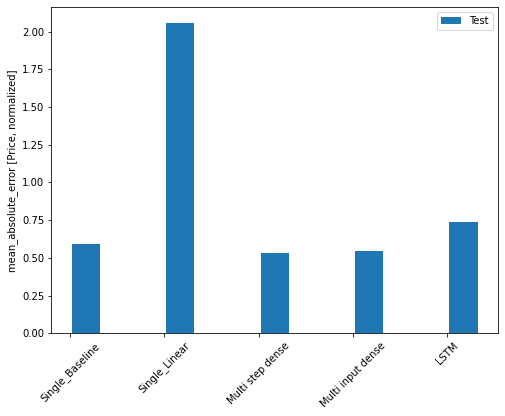

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, normalized]')
# plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

#### Multiple Steps

Here we use 6m data to predict future 6m

Total window size: 12
Input indices: [0 1 2 3 4 5]
Label indices: [ 6  7  8  9 10 11]
Label column name(s): ['PRICE']

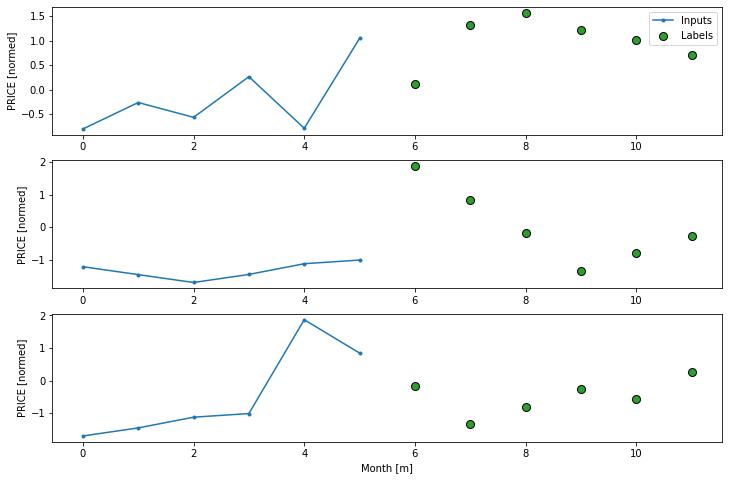

In [ ]:
OUT_STEPS = 6
multi_window = WindowGenerator(input_width=6,
                               label_width=6,
                               shift=OUT_STEPS,
                               label_columns = ['PRICE'])

multi_window.plot(max_subplots = 3)
multi_window

##### Baseline

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

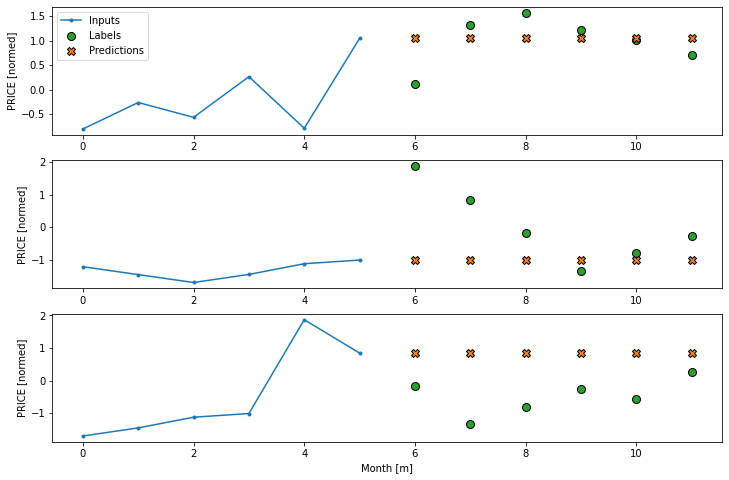

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])


multi_performance = {}


multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

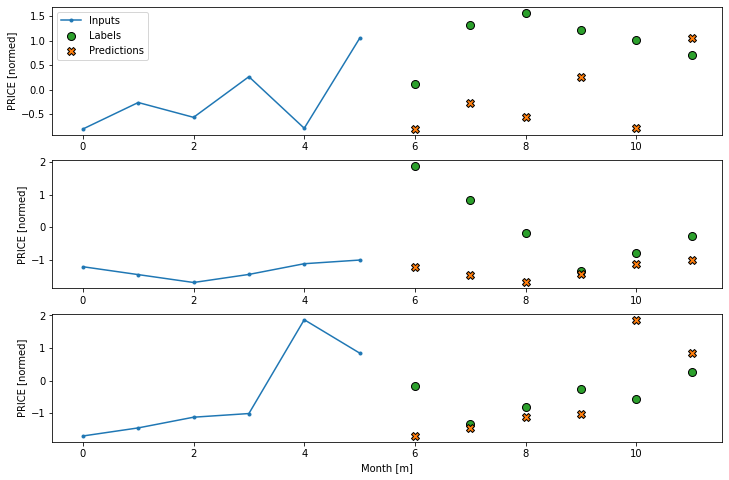

In [ ]:
#this baseline just repeat the past 6m into the future
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])


multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

##### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

Epoch 1/20
2/2 [==============================] - 1s 167ms/step - loss: 0.6877 - mean_absolute_error: 0.6643 - val_loss: 0.8136 - val_mean_absolute_error: 0.7890
Epoch 2/20
2/2 [==============================] - 0s 56ms/step - loss: 0.6858 - mean_absolute_error: 0.6631 - val_loss: 0.8097 - val_mean_absolute_error: 0.7866
Epoch 3/20
2/2 [==============================] - 0s 57ms/step - loss: 0.6841 - mean_absolute_error: 0.6620 - val_loss: 0.8060 - val_mean_absolute_error: 0.7843
Epoch 4/20
2/2 [==============================] - 0s 56ms/step - loss: 0.6825 - mean_absolute_error: 0.6608 - val_loss: 0.8025 - val_mean_absolute_error: 0.7821
Epoch 5/20
2/2 [==============================] - 0s 56ms/step - loss: 0.6809 - mean_absolute_error: 0.6597 - val_loss: 0.7991 - val_mean_absolute_error: 0.7800
Epoch 6/20
2/2 [==============================] - 0s 54ms/step - loss: 0.6791 - mean_absolute_error: 0.6586 - val_loss: 0.7958 - val_mean_absolute_error: 0.7780
Epoch 7/20
2/2 [=================

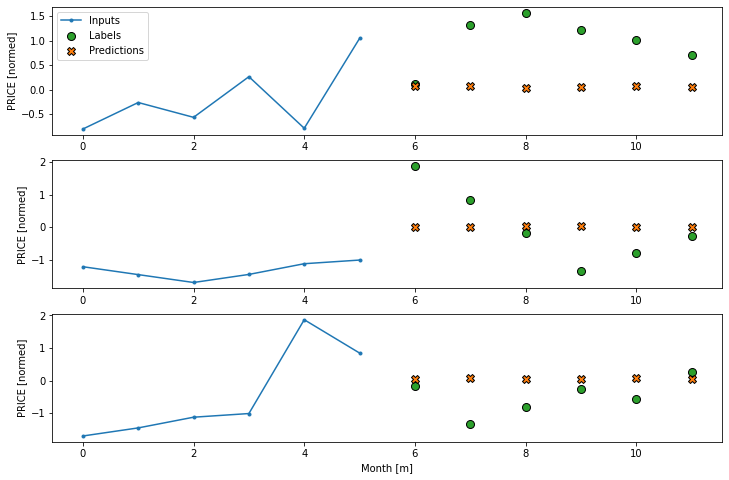

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_linear_model, multi_window)

# IPython.display.clear_output()

multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

##### Dense

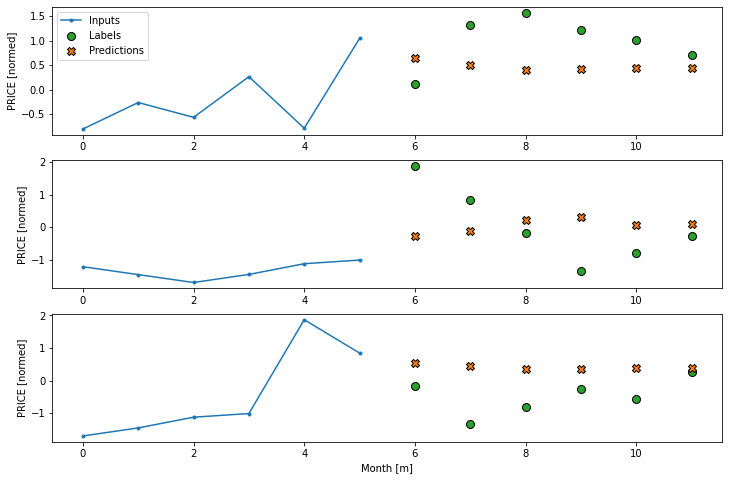

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

##### RNN



Epoch 1/20
2/2 [==============================] - 3s 489ms/step - loss: 0.6875 - mean_absolute_error: 0.6642 - val_loss: 0.8106 - val_mean_absolute_error: 0.7870
Epoch 2/20
2/2 [==============================] - 0s 58ms/step - loss: 0.6848 - mean_absolute_error: 0.6620 - val_loss: 0.8045 - val_mean_absolute_error: 0.7831
Epoch 3/20
2/2 [==============================] - 0s 58ms/step - loss: 0.6823 - mean_absolute_error: 0.6600 - val_loss: 0.7980 - val_mean_absolute_error: 0.7789
Epoch 4/20
2/2 [==============================] - 0s 58ms/step - loss: 0.6795 - mean_absolute_error: 0.6579 - val_loss: 0.7907 - val_mean_absolute_error: 0.7742
Epoch 5/20
2/2 [==============================] - 0s 63ms/step - loss: 0.6766 - mean_absolute_error: 0.6554 - val_loss: 0.7827 - val_mean_absolute_error: 0.7689
Epoch 6/20
2/2 [==============================] - 0s 60ms/step - loss: 0.6735 - mean_absolute_error: 0.6528 - val_loss: 0.7738 - val_mean_absolute_error: 0.7630
Epoch 7/20
2/2 [=================

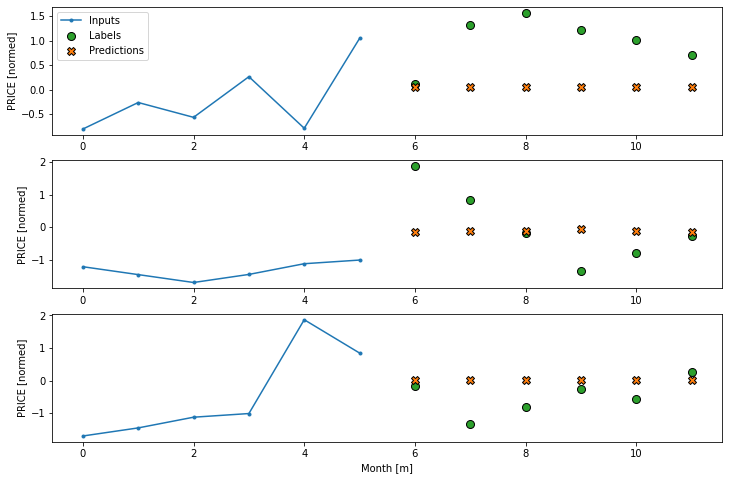

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

##### Advanced: Autoregressive model

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([24, 1])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (24, 6, 1)


Epoch 1/20
2/2 [==============================] - 3s 1s/step - loss: 0.6569 - mean_absolute_error: 0.6335 - val_loss: 0.6963 - val_mean_absolute_error: 0.7027
Epoch 2/20
2/2 [==============================] - 0s 63ms/step - loss: 0.6433 - mean_absolute_error: 0.6204 - val_loss: 0.6544 - val_mean_absolute_error: 0.6702
Epoch 3/20
2/2 [==============================] - 0s 63ms/step - loss: 0.6305 - mean_absolute_error: 0.6090 - val_loss: 0.6149 - val_mean_absolute_error: 0.6379
Epoch 4/20
2/2 [==============================] - 0s 61ms/step - loss: 0.6199 - mean_absolute_error: 0.6011 - val_loss: 0.5793 - val_mean_absolute_error: 0.6072
Epoch 5/20
2/2 [==============================] - 0s 61ms/step - loss: 0.6092 - mean_absolute_error: 0.5945 - val_loss: 0.5460 - val_mean_absolute_error: 0.5768
Epoch 6/20
2/2 [==============================] - 0s 63ms/step - loss: 0.6009 - mean_absolute_error: 0.5892 - val_loss: 0.5152 - val_mean_absolute_error: 0.5475
Epoch 7/20
2/2 [====================

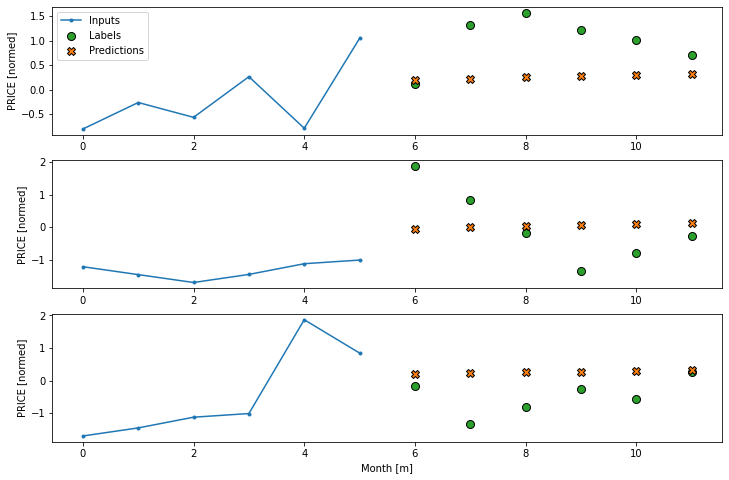

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

##### Performance

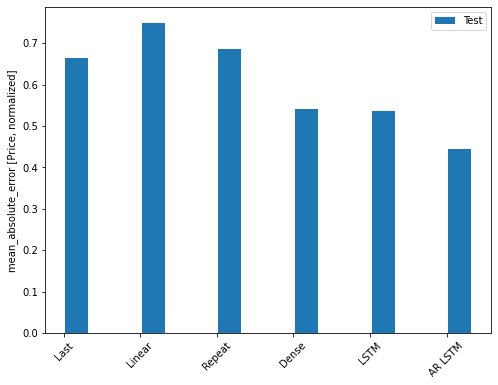

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.ylabel('mean_absolute_error [Price, normalized]')
# plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

We think the RNN in tensorflow failed to converage. It is true that deciding on how many past time periods are appropriate to predict how far in the future with RNN model and the model tuning is also computational expensive. Also, unlike the prediction of weather of which the time inverval between 2 observation time slots is fixed or can be fixed based on the sensors, the sales of property is random, e.g. sometimes 2 properties were sold within a day, while sometimes no sale for the whole month (i.e. the time interval will be larger than 1 month). Also, the time interval may affect the housing price itself. As a result, even though RNN can use previous output as one of the input in the next processing, the effect from the previous output may be various. Therefore, we need to do more research and try more on how to do the data engineering before we apply RNN on the house price prediction.

## Scale up using Spark

In [2]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("finalproj")\
        .getOrCreate()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15

In [5]:
df_spark = spark\
  .read\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .csv("/content/drive/Shareddrives/BAX423_Final_Project/Data/Combine.csv")

In [6]:
df_spark.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- SALE TYPE: string (nullable = true)
 |-- SOLD DATE: string (nullable = true)
 |-- PROPERTY TYPE: string (nullable = true)
 |-- ADDRESS: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE OR PROVINCE: string (nullable = true)
 |-- ZIP OR POSTAL CODE: string (nullable = true)
 |-- PRICE: double (nullable = true)
 |-- BEDS: double (nullable = true)
 |-- BATHS: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- SQUARE FEET: double (nullable = true)
 |-- LOT SIZE: double (nullable = true)
 |-- YEAR BUILT: double (nullable = true)
 |-- DAYS ON MARKET: double (nullable = true)
 |-- $/SQUARE FEET: double (nullable = true)
 |-- HOA/MONTH: double (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- NEXT OPEN HOUSE START TIME: string (nullable = true)
 |-- NEXT OPEN HOUSE END TIME: string (nullable = true)
 |-- URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING): st

In [7]:
df_spark.createOrReplaceTempView("df_spark")
# check whether there are any transactions without description
df_cut_spark = spark.sql("""
SELECT `SOLD DATE`, PRICE, `ZIP OR POSTAL CODE`, `PROPERTY TYPE`,BEDS,BATHS,`SQUARE FEET`,
FROM df_spark
""")

df_cut_spark.show()

+-----------------+---------+------------------+--------------------+
|        SOLD DATE|    PRICE|ZIP OR POSTAL CODE|       PROPERTY TYPE|
+-----------------+---------+------------------+--------------------+
| December-29-2017| 725000.0|           94040.0|         Condo/Co-op|
|     July-18-2018|2650000.0|           94040.0|Single Family Res...|
| November-21-2018| 710000.0|           94040.0|         Condo/Co-op|
|     June-23-2020|1200000.0|           94040.0|         Condo/Co-op|
|    March-11-2021|1500000.0|           94040.0|           Townhouse|
|    March-16-2017|1850000.0|           94040.0|Single Family Res...|
|       May-7-2019|2799000.0|           94040.0|Single Family Res...|
|     June-11-2020|1500000.0|           94040.0|           Townhouse|
|      May-25-2016|2000000.0|           94040.0|Single Family Res...|
|      May-19-2016|1375000.0|           94087.0|Single Family Res...|
|  October-16-2020|2550000.0|           94040.0|Single Family Res...|
|    April-22-2019|1

In [ ]:
# zip1 = housing[housing['ZIP OR POSTAL CODE'] == 94040]
# zip1 = zip1.sort_values(by=['SOLD DATE'])

# zip1 = zip1[['SOLD DATE','PRICE']]
# zip1.columns = ['SOLD_DATE','PRICE']
# zip1.reset_index(drop = True)
# zip1.head()

# zip2 = spark.createDataFrame(zip1)
# zip2.createOrReplaceTempView("df")
# # check whether there are any transactions without description
# avg_price = spark.sql("""
# SELECT LEFT(SOLD_DATE, 7) AS Date, round(avg(PRICE),0) as AVG_PRICE
# FROM df
# group by LEFT(SOLD_DATE, 7)
# order by 1
# """)
# dataset = avg_price.toPandas()

# #dataset.set_index('Date', inplace = True)
# dataset.shape


# import math
# import matplotlib.pyplot as plt
# import keras
# import pandas as pd
# import numpy as np
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout
# from keras.layers import *
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import train_test_split
# from keras.callbacks import EarlyStopping

# # split into train and test sets
# training_set = dataset.iloc[:50, 1:2].values
# test_set = dataset.iloc[50:, 1:2].values


# # Feature Scaling
# sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(training_set)
# # Creating a data structure with 60 time-steps and 1 output
# X_train = []
# y_train = []
# for i in range(10, 50):
#     X_train.append(training_set_scaled[i-10:i, 0])
#     y_train.append(training_set_scaled[i, 0])
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# print(X_train.shape)




# model = Sequential()
# #Adding the first LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# # Adding a second LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))
# # Adding a third LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))
# # Adding a fourth LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))
# # Adding the output layer
# model.add(Dense(units = 1))

# # Compiling the RNN
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# # Fitting the RNN to the Training set
# model.fit(X_train, y_train, epochs = 100, batch_size = 32)


# # Getting the predicted stock price of 2017
# dataset_train = dataset.iloc[:50, 1:2]
# dataset_test = dataset.iloc[50:, 1:2]
# dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(dataset_test) - 10:].values
# inputs = inputs.reshape(-1,1)
# inputs = sc.transform(inputs)
# X_test = []
# for i in range(10, 21):
#     X_test.append(inputs[i-10:i, 0])
# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# print(X_test.shape)


# predicted_stock_price = model.predict(X_test)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# predicted_stock_price

# dataset.tail(11)

# # Visualising the results
# plt.plot(dataset.loc[50:,'Date'],dataset_test.values, color = 'red', label = 'Real Price')
# plt.plot(dataset.loc[50:,'Date'],predicted_stock_price, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,50,1))
# plt.title('Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Real Price')
# plt.legend()
# plt.show()

# zip1 = housing[housing['ZIP OR POSTAL CODE'] == 94040]
# zip1 = zip1.sort_values(by=['SOLD DATE'])
# zip1.reset_index(drop = True)